In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

import seaborn as sns

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

import ssa_calc

import astropy.units as u
from astropy.time import Time

# Creating a curve_fit on the temperature data:
from scipy.optimize import curve_fit, fsolve

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

Num GPUs Available:  1


In [2]:
# Path to interpolators:
POS_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-c3-pos-interpolator-2008-04-28-to-2022-10-23.pkl"
VEL_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-c3-vel-interpolator-2008-04-28-to-2022-10-23.pkl"
delfi_c3 = ssa_calc.Satellite(POS_INTERP_PATH, VEL_INTERP_PATH)

Loading interpolators from pickle files...
Interpolators loaded.


In [3]:
# Loading telemetry data:
TELEM_SAVE_PATH = r"../telemetry-files/delfi-c3/processed-2008-2022/delfi-c3-telemetry-processed-2009.hdf"
frames_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="frames_raw")
frames_df = pd.read_hdf(TELEM_SAVE_PATH, key="frames")
housekeeping_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping_raw")
housekeeping_df = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping")
payload_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="payload_raw")
payload_df = pd.read_hdf(TELEM_SAVE_PATH, key="payload")

In [14]:
# Analysis time frame:
start_time = Time("2009-01-05T00:00:00", format="isot", scale="utc")
end_time = Time("2009-02-28T00:00:00", format="isot", scale="utc")



In [5]:
# Processing hk_df:
hk_df = housekeeping_df[housekeeping_df["Time (jd)"] < end_time.jd]
pass_number = 0
hk_df.loc[0, "Pass number"] = pass_number
with alive_bar(len(hk_df), theme="classic", force_tty=True) as bar:
    for i, row in hk_df.iterrows():
        # Get the index of the corresponding FrameID in the frames_df:
        frame_id = row["FrameID"]
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]
        # Get the corresponding reception time:
        reception_time = frames_df.loc[frame_index, "Corrected Reception Time"]
        hk_df.loc[i, "corrected reception time"] = reception_time
        # Get the corresponding theoretical theta_T:
        temp_vals = delfi_c3.calc_beta_fe_theta(Time(reception_time, format="iso", scale="utc"))
        hk_df.loc[i, "theoretical theta_T"] = temp_vals[3].to(u.deg).value

        if i==0:
            bar()
            continue
            
        # Check if the pass number has changed:
        if hk_df.loc[i, "Time (jd)"] - hk_df.loc[i-1, "Time (jd)"] > 1/24:
            pass_number += 1
        hk_df.loc[i, "Pass number"] = pass_number
        bar()


C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\2721383206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_df.loc[0, "Pass number"] = pass_number


on 0: C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\2721383206.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]
C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\2721383206.py:12: SettingWithCopyWarning: 
      A value is trying to be set on a copy of a slice from a DataFrame.
      Try using .loc[row_indexer,col_indexer] = value instead
      
      See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
        hk_df.loc[i, "corrected reception time"] = reception_time
C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\2721383206.py:15: SettingWithCopyWarning: 
      A value is trying to be set on a copy of a slice from a DataFrame.
      Try using .loc[row_indexer,col_indexer] = value instead
      
      See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

on 1: C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\2721383206.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]


[========================================] 12572/12572 [100%] in 3:07.6 (67.01/s)                                       


In [15]:
# Doing the same for the payload data:
pl_df = payload_df[payload_df["Time (jd)"] < end_time.jd]
pass_number = 0
pl_df.loc[0, "Pass number"] = pass_number
with alive_bar(len(pl_df), theme="classic", force_tty=True) as bar:
    for i, row in pl_df.iterrows():
        # Get the index of the corresponding FrameID in the frames_df:
        frame_id = row["FrameID"]
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]
        # Get the corresponding reception time:
        reception_time = frames_df.loc[frame_index, "Corrected Reception Time"]
        pl_df.loc[i, "corrected reception time"] = reception_time
        # Get the corresponding theoretical theta_T:
        temp_vals = delfi_c3.calc_beta_fe_theta(Time(reception_time, format="iso", scale="utc"))
        pl_df.loc[i, "theoretical theta_T"] = temp_vals[3].to(u.deg).value

        if i==0:
            bar()
            continue
            
        # Check if the pass number has changed:
        if pl_df.loc[i, "Time (jd)"] - pl_df.loc[i-1, "Time (jd)"] > 1/24:
            pass_number += 1
        pl_df.loc[i, "Pass number"] = pass_number
        bar()

C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\3747156470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df.loc[0, "Pass number"] = pass_number


on 0: C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\3747156470.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]
C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\3747156470.py:12: SettingWithCopyWarning: 
      A value is trying to be set on a copy of a slice from a DataFrame.
      Try using .loc[row_indexer,col_indexer] = value instead
      
      See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
        pl_df.loc[i, "corrected reception time"] = reception_time
C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\3747156470.py:15: SettingWithCopyWarning: 
      A value is trying to be set on a copy of a slice from a DataFrame.
      Try using .loc[row_indexer,col_indexer] = value instead
      
      See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

on 1: C:\Users\ullas\AppData\Local\Temp\ipykernel_20772\3747156470.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
        frame_index = frames_df[frames_raw_df["FrameID"] == frame_id].index[0]


[========================================] 4845/4845 [100%] in 1:15.6 (64.10/s)                                         


In [19]:
for i, row in pl_df.iterrows():
    if row["theta_T (deg)"] > 150:
        pl_df.loc[i] = np.nan
    if row["TFSC Z+X+ Temperature (K)"] < 100:
        pl_df.loc[i, "TFSC Z+X+ Temperature (K)"] = np.nan
    if row["TFSC Z+X- Temperature (K)"] < 100:
        pl_df.loc[i, "TFSC Z+X- Temperature (K)"] = np.nan
    if row["TFSC Z-Y+ Temperature (K)"] < 100:
        pl_df.loc[i, "TFSC Z-Y+ Temperature (K)"] = np.nan
    if row["TFSC Z-Y- Temperature (K)"] < 100:
        pl_df.loc[i, "TFSC Z-Y- Temperature (K)"] = np.nan

pl_df = pl_df.dropna().reset_index(drop=True)

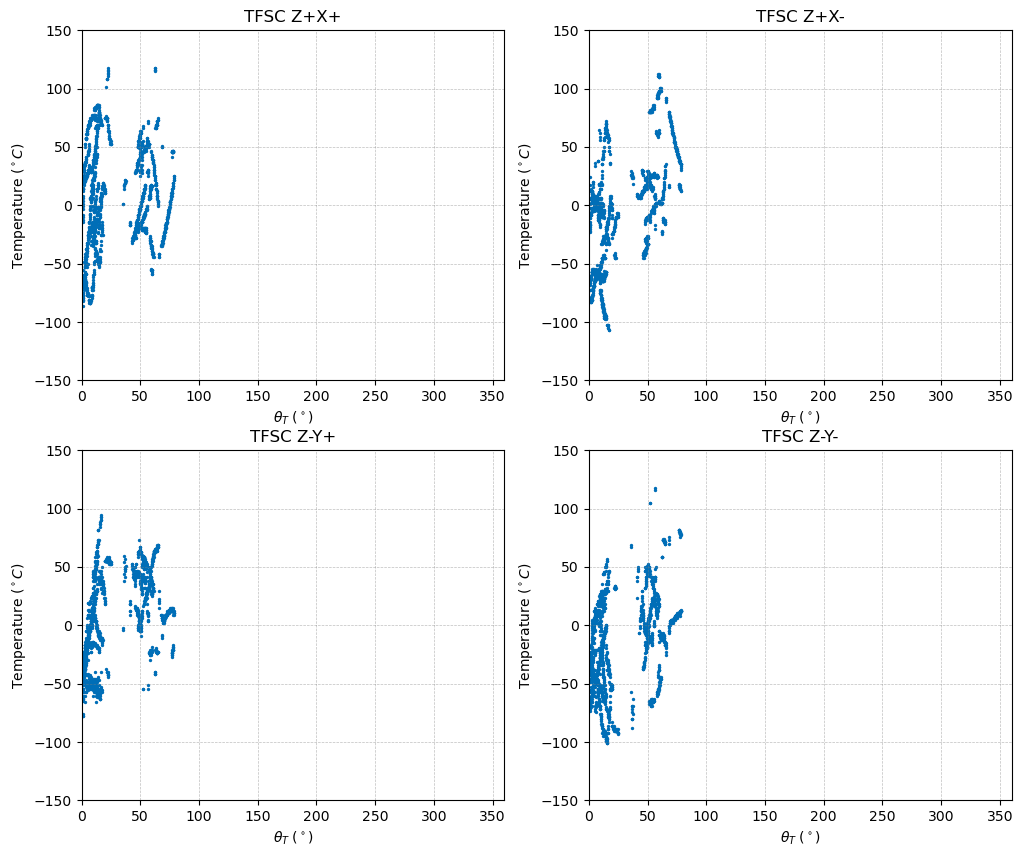

In [20]:
# Plotting the data:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(
    pl_df["theta_T (deg)"].to_numpy(),
    pl_df["TFSC Z+X+ Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z+X+")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-150, 150)

plt.subplot(2, 2, 2)
plt.scatter(
    pl_df["theta_T (deg)"].to_numpy(),
    pl_df["TFSC Z+X- Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z+X-")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-150, 150)

plt.subplot(2, 2, 3)
plt.scatter(
    pl_df["theta_T (deg)"].to_numpy(),
    pl_df["TFSC Z-Y+ Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z-Y+")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-150, 150)

plt.subplot(2, 2, 4)
plt.scatter(
    pl_df["theta_T (deg)"].to_numpy(),
    pl_df["TFSC Z-Y- Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z-Y-")
plt.grid()
plt.xlim(0, 360)
plt.ylim(-150, 150)

plt.show()


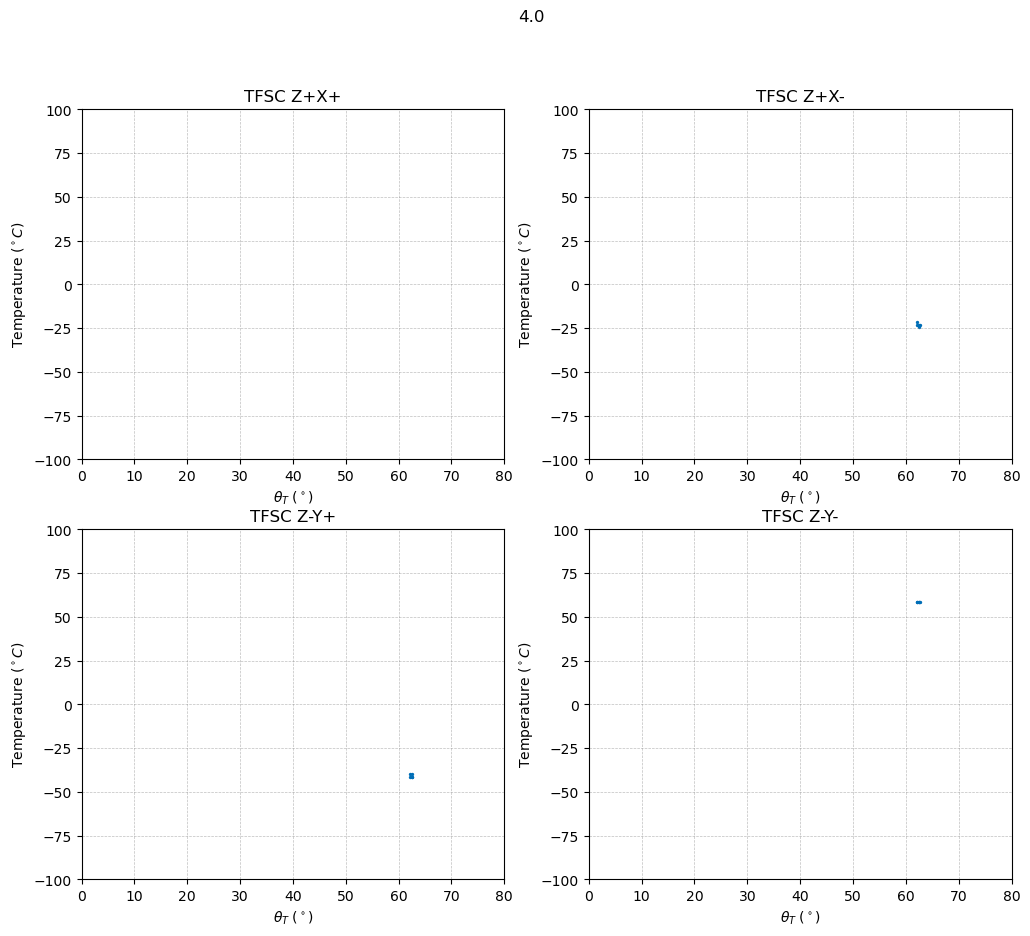

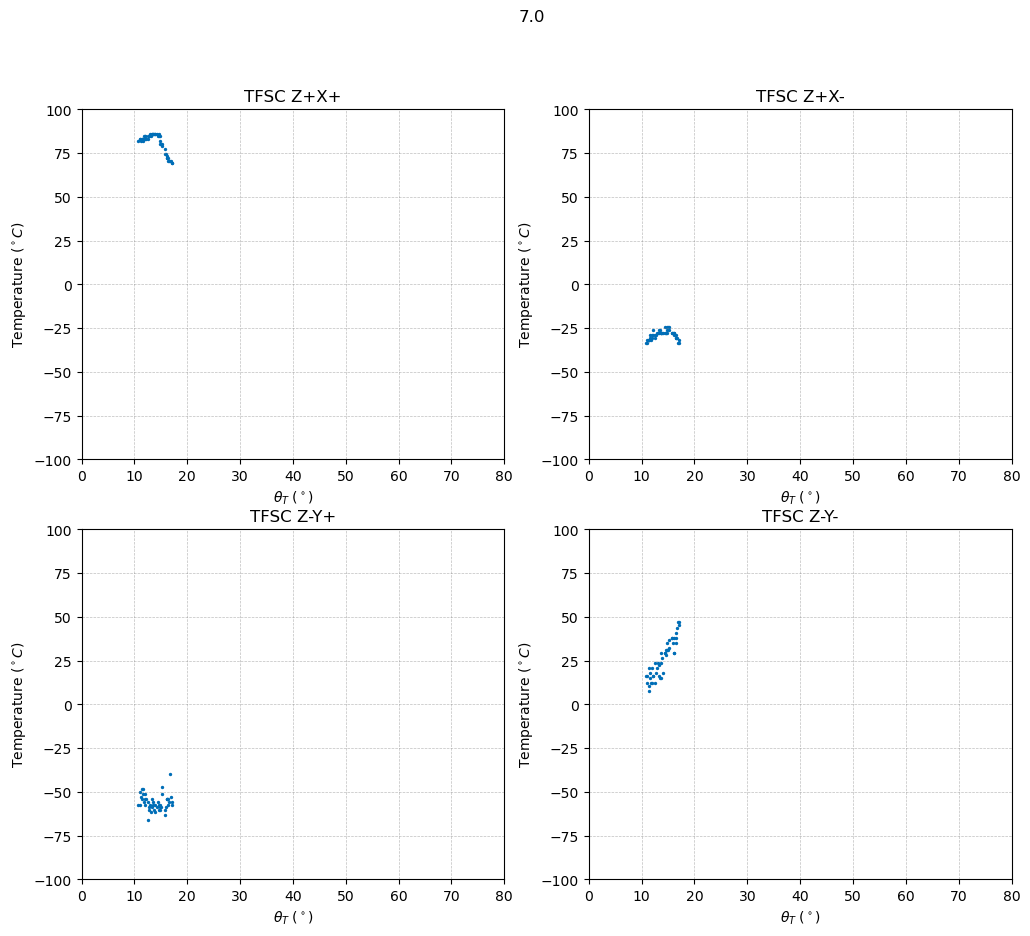

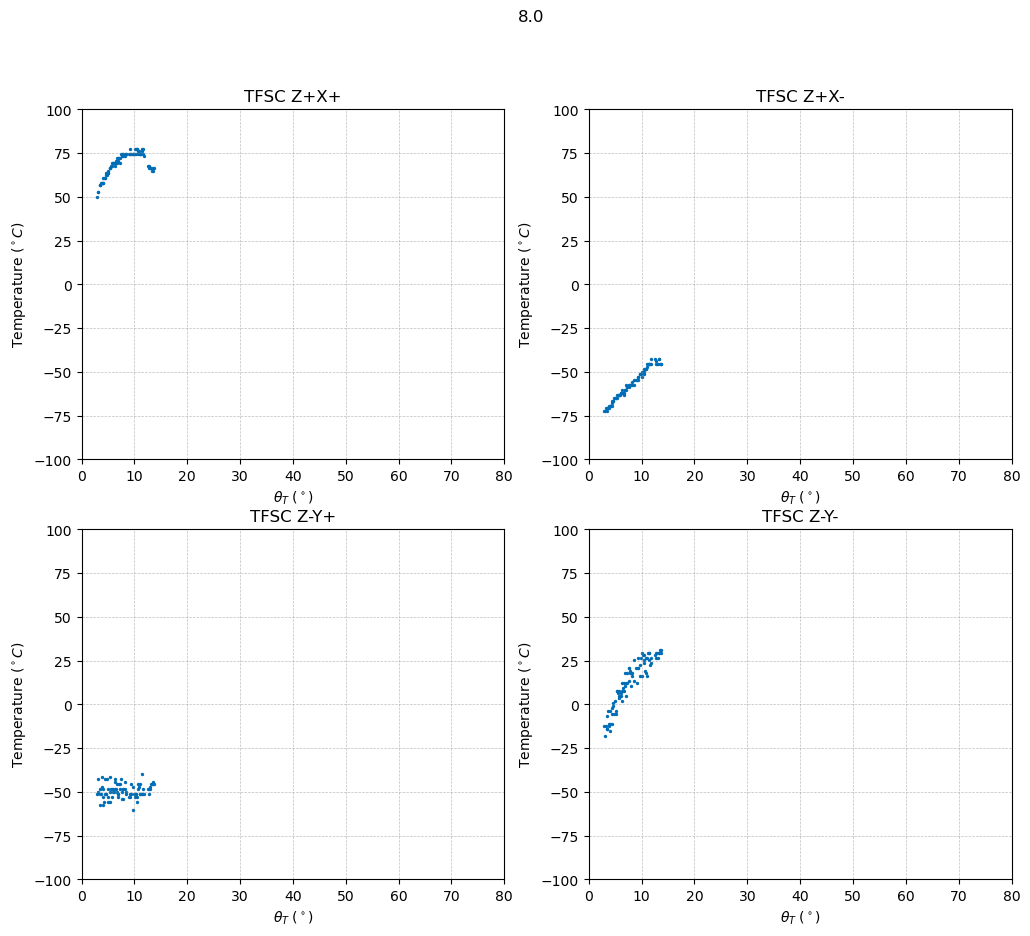

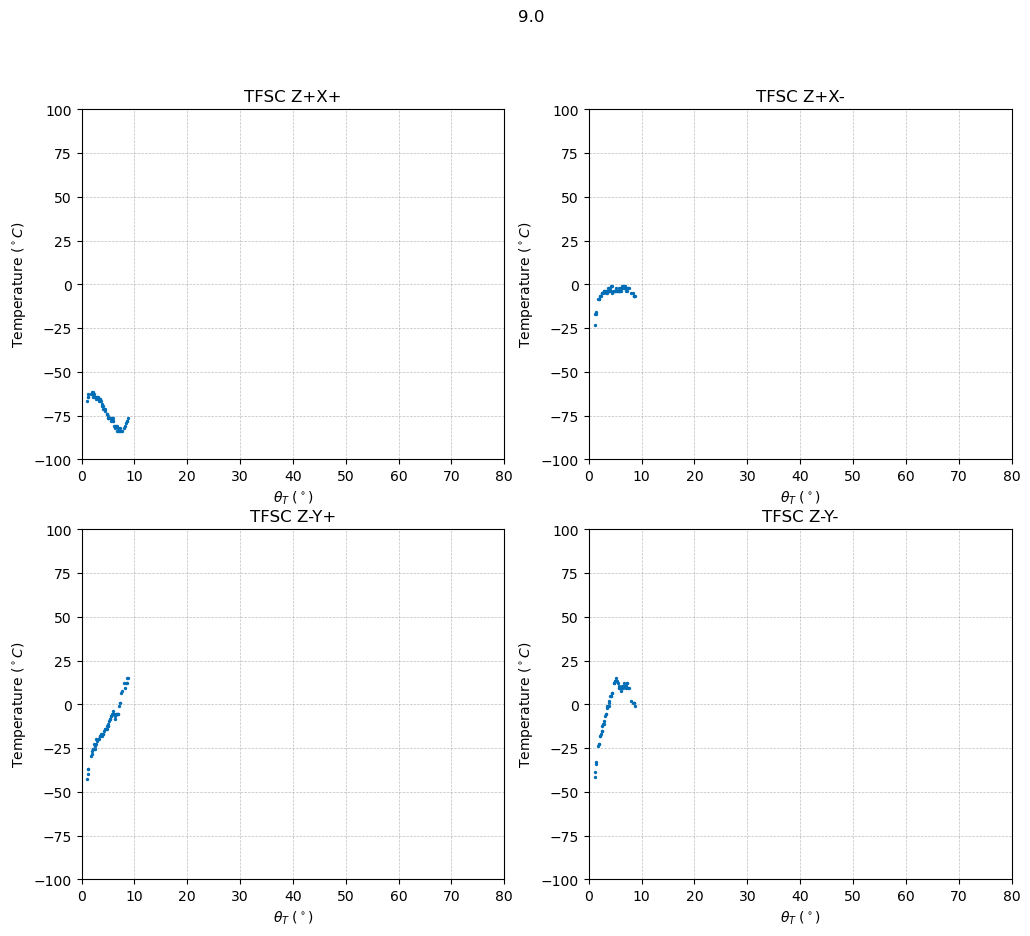

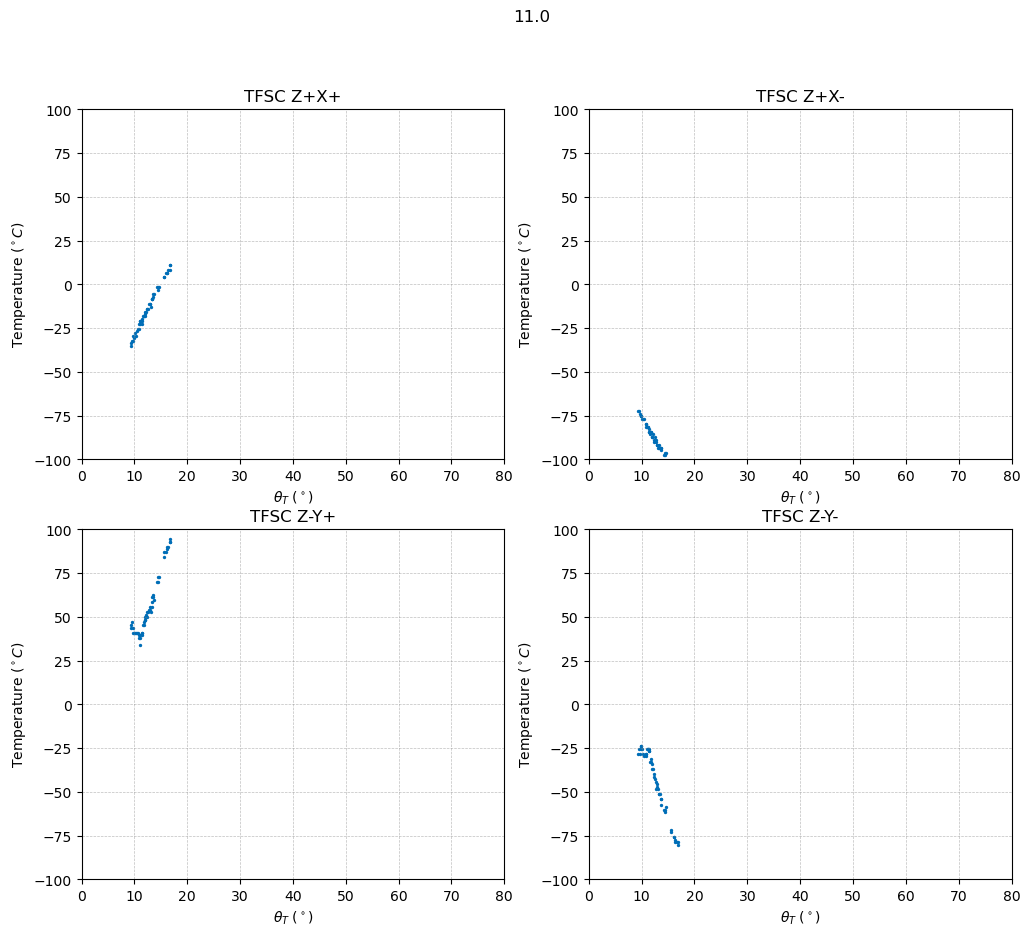

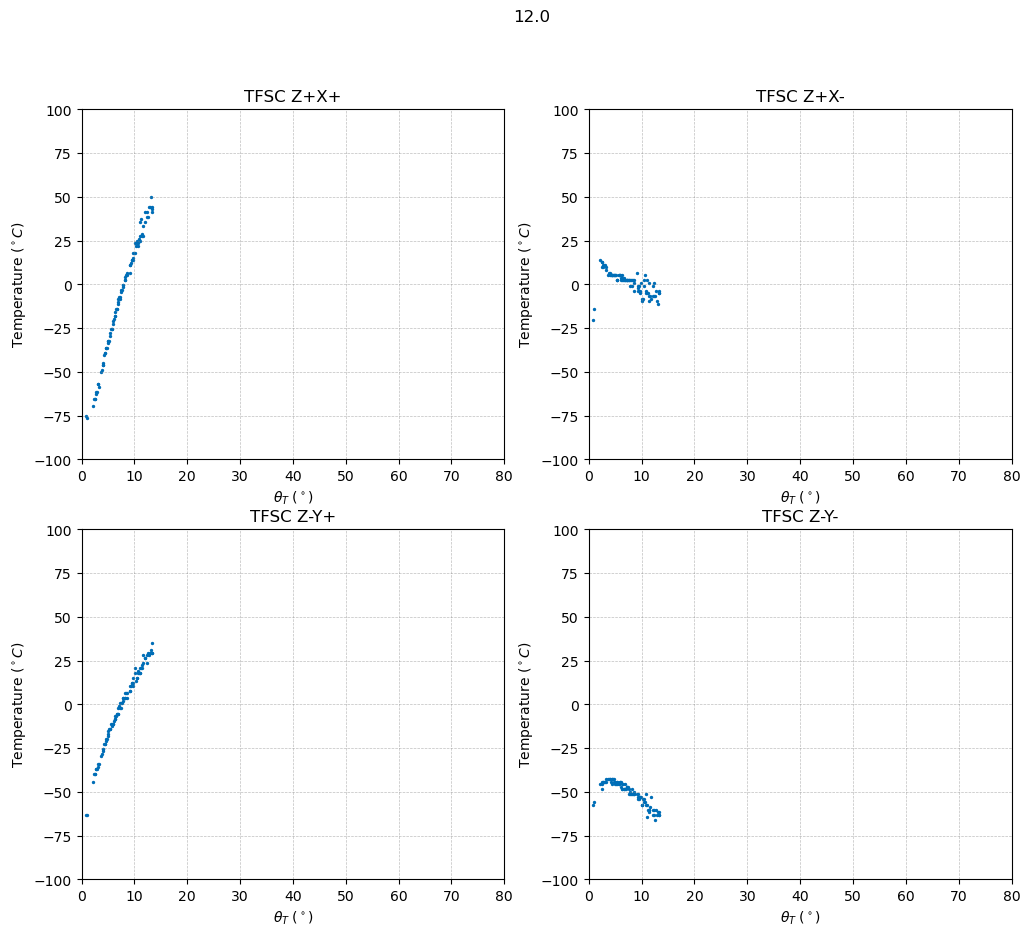

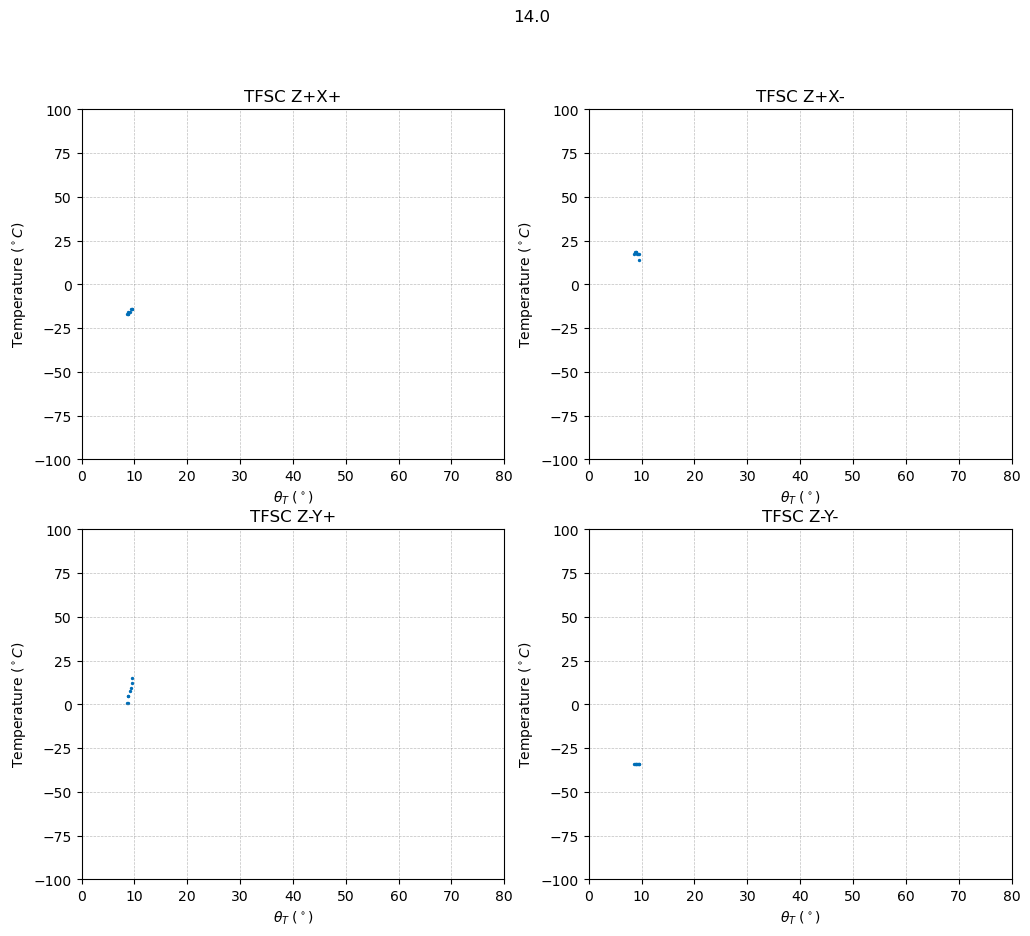

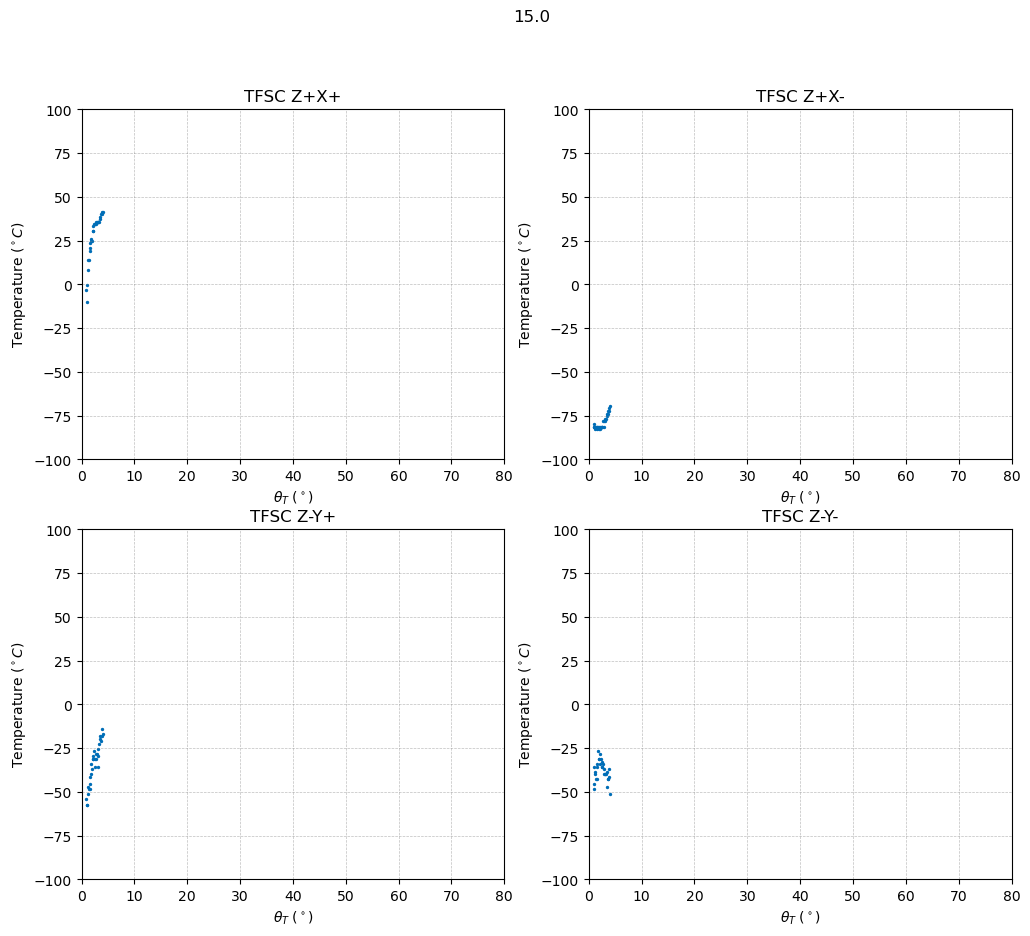

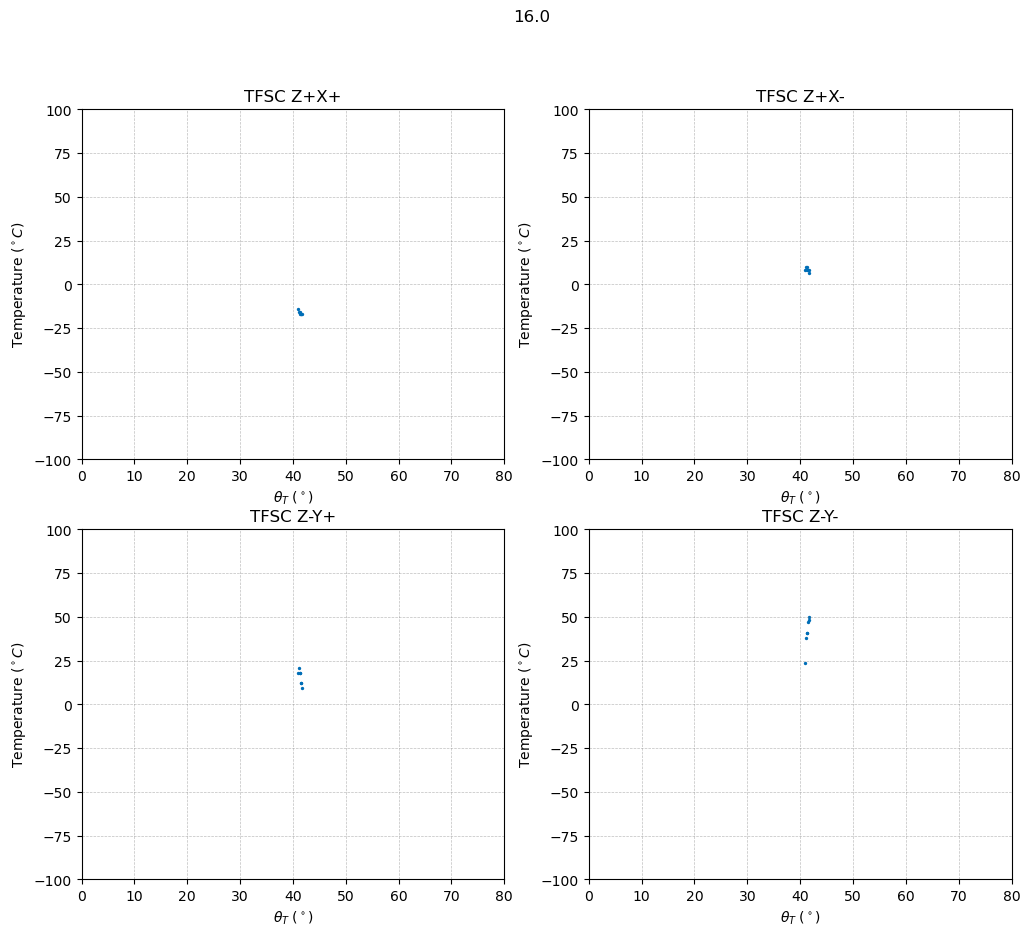

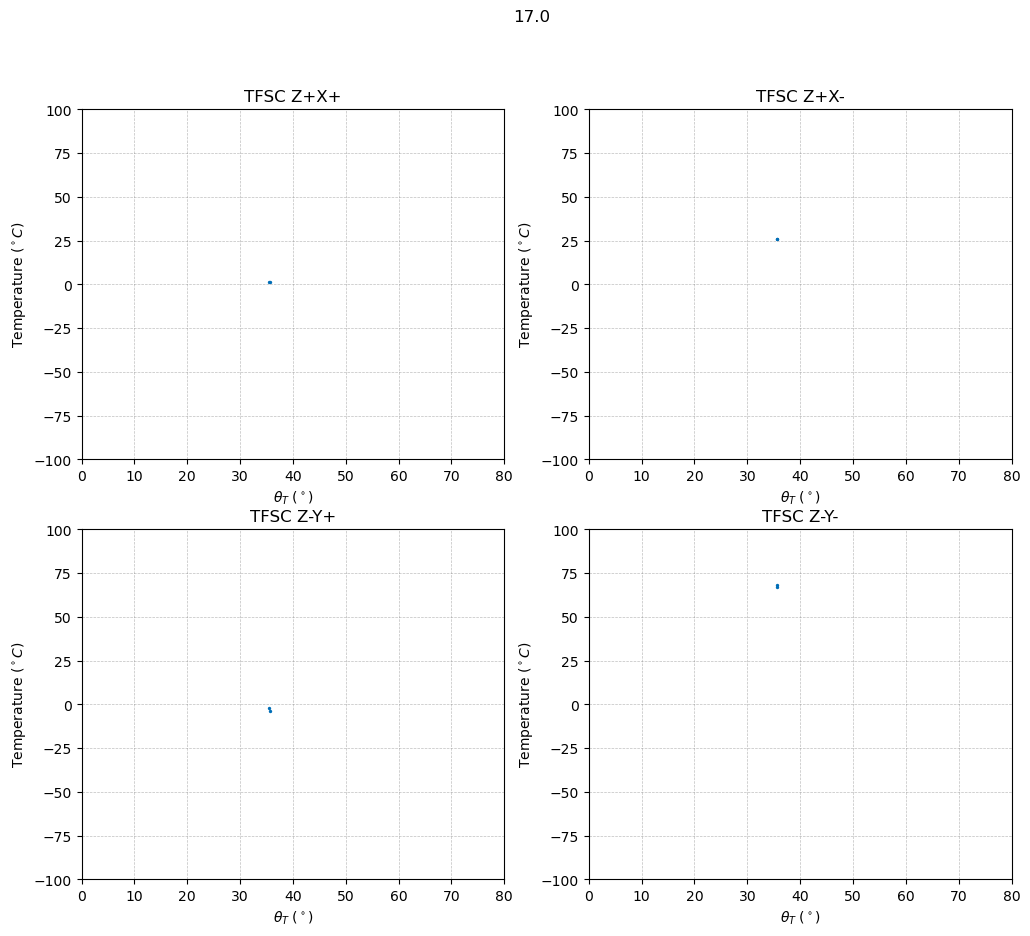

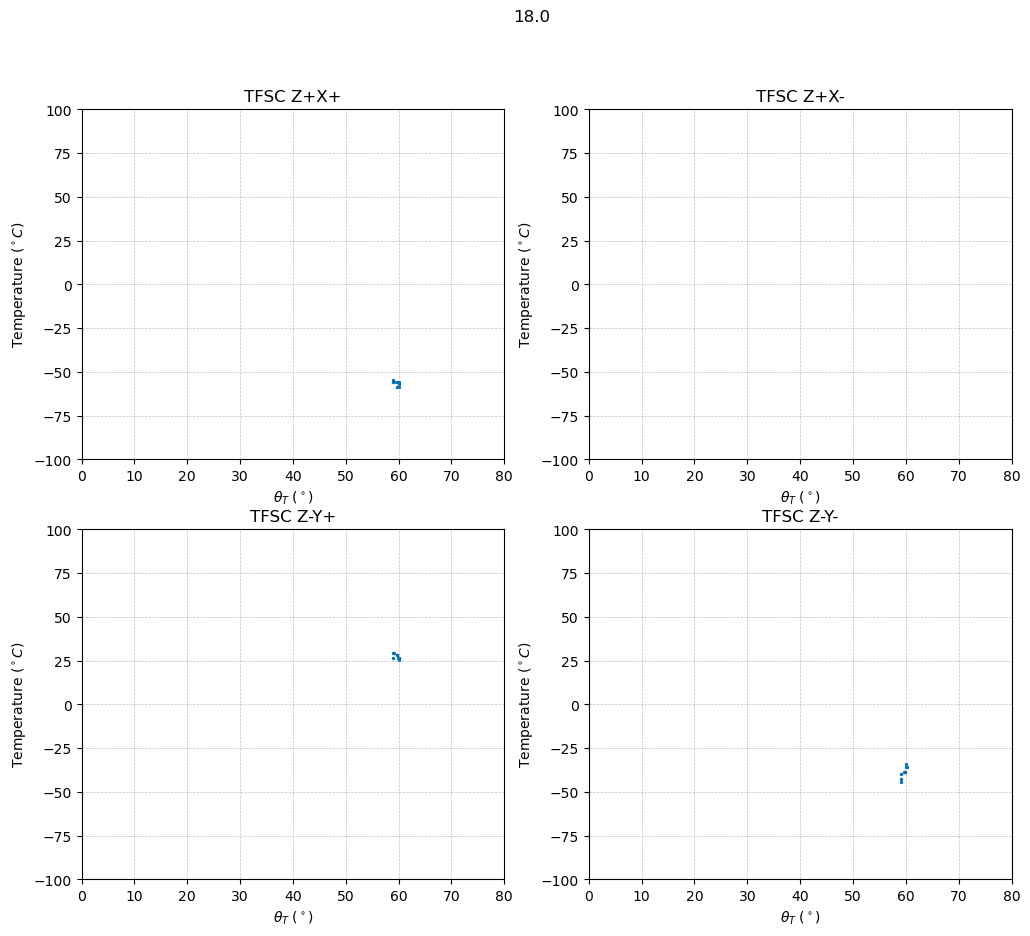

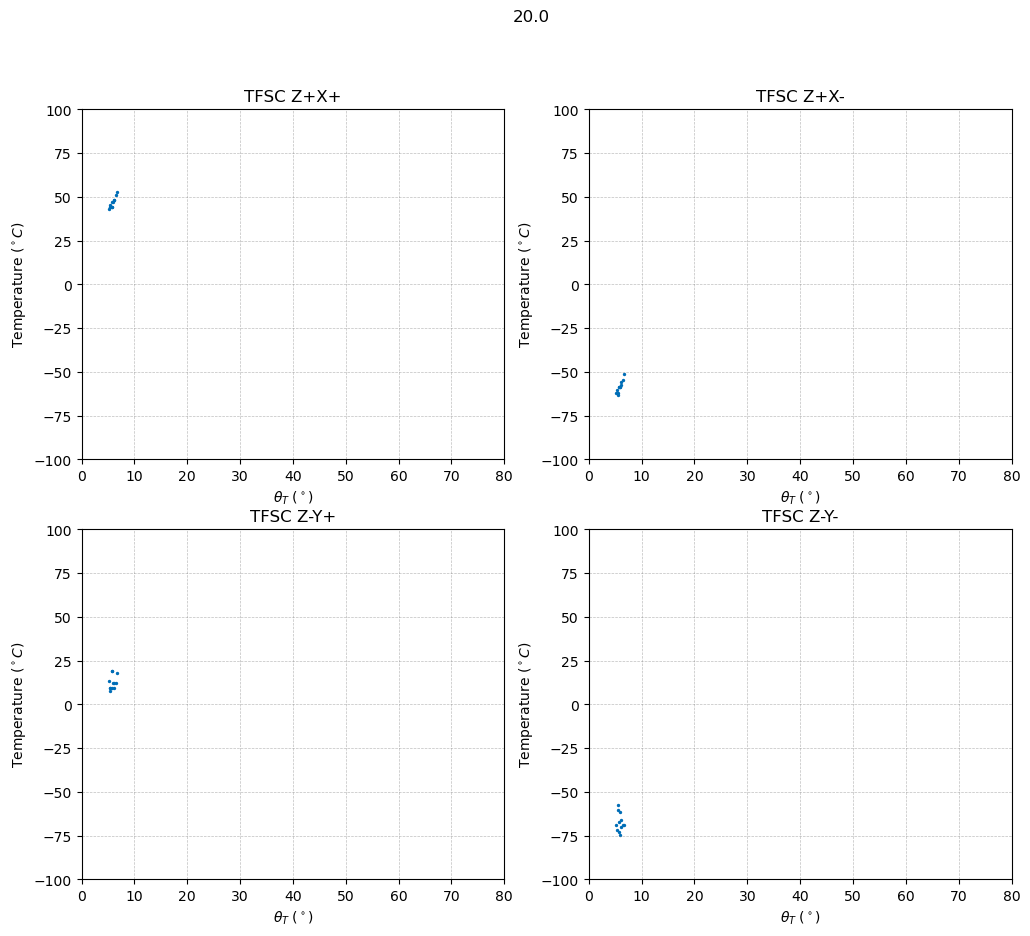

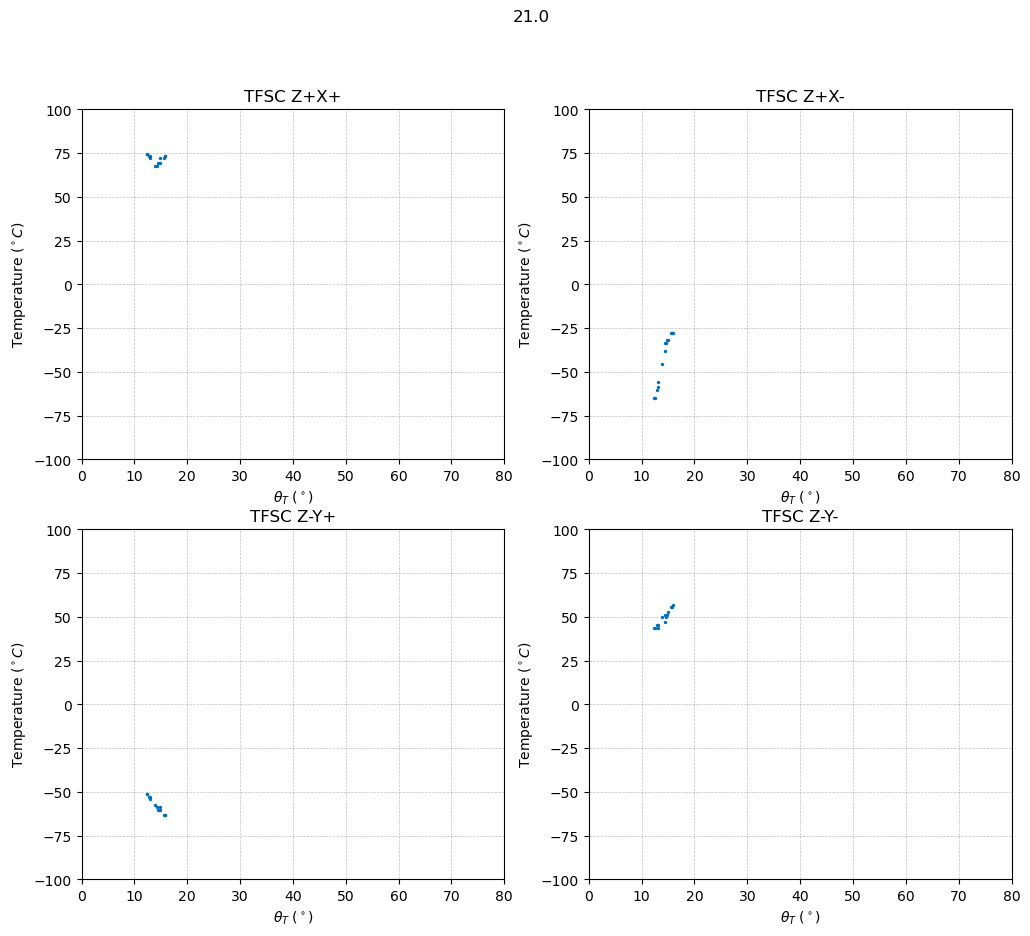

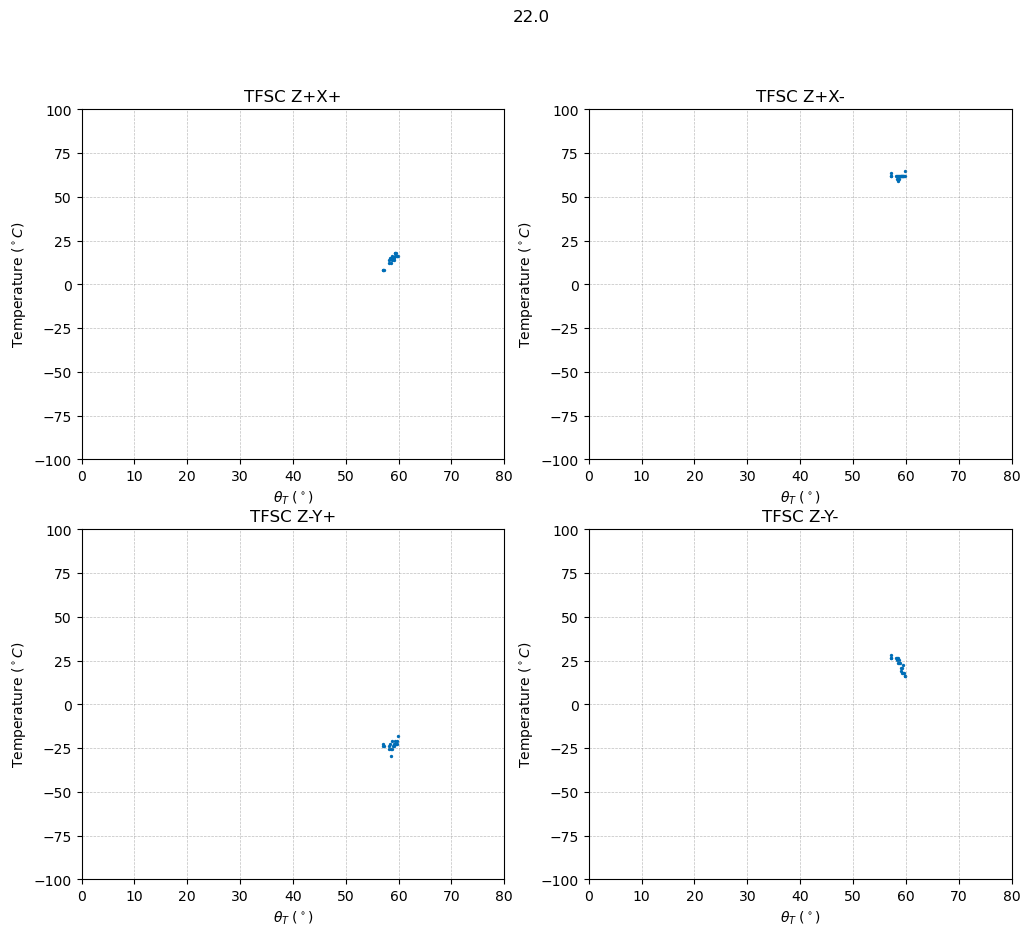

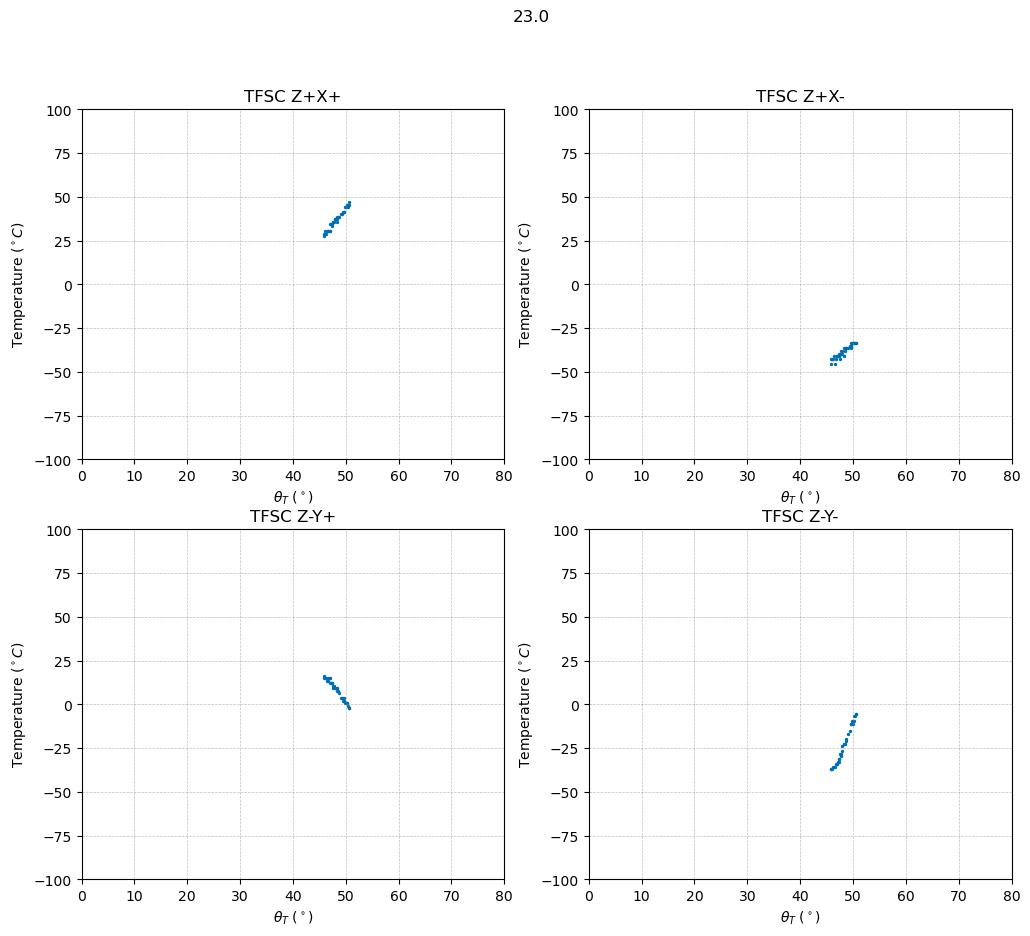

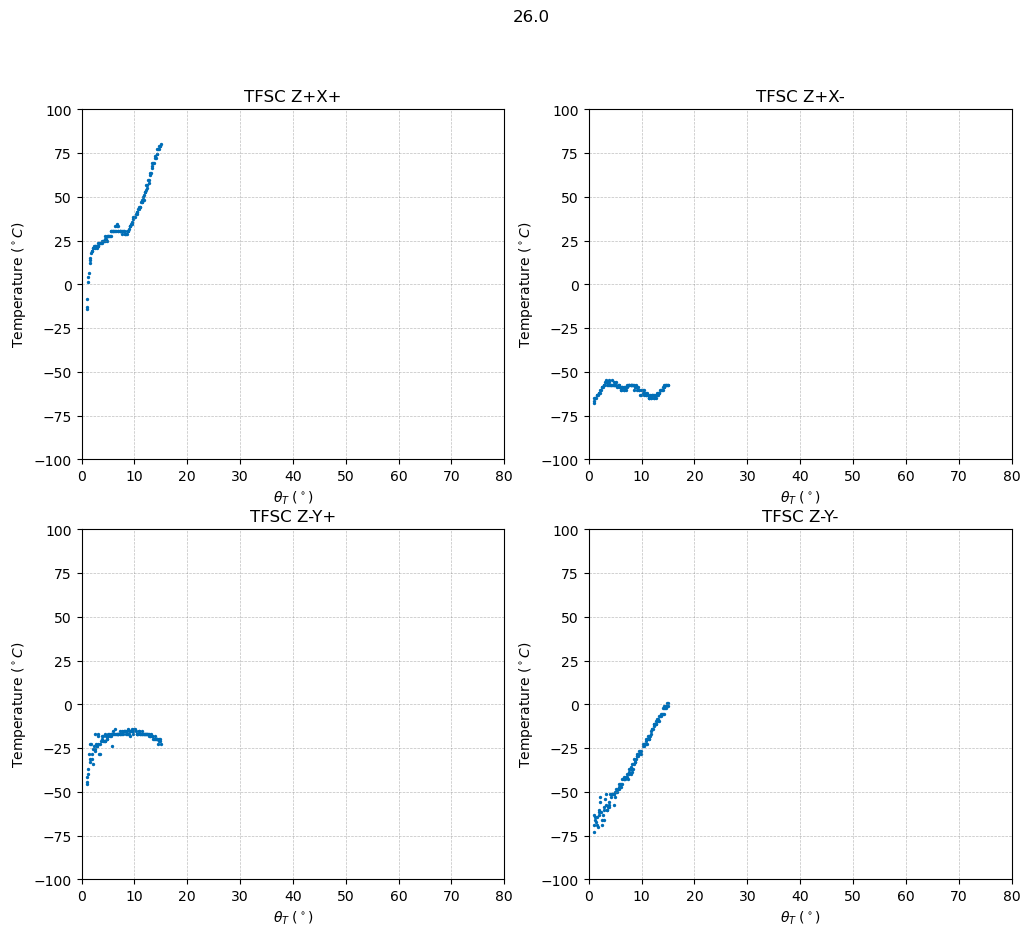

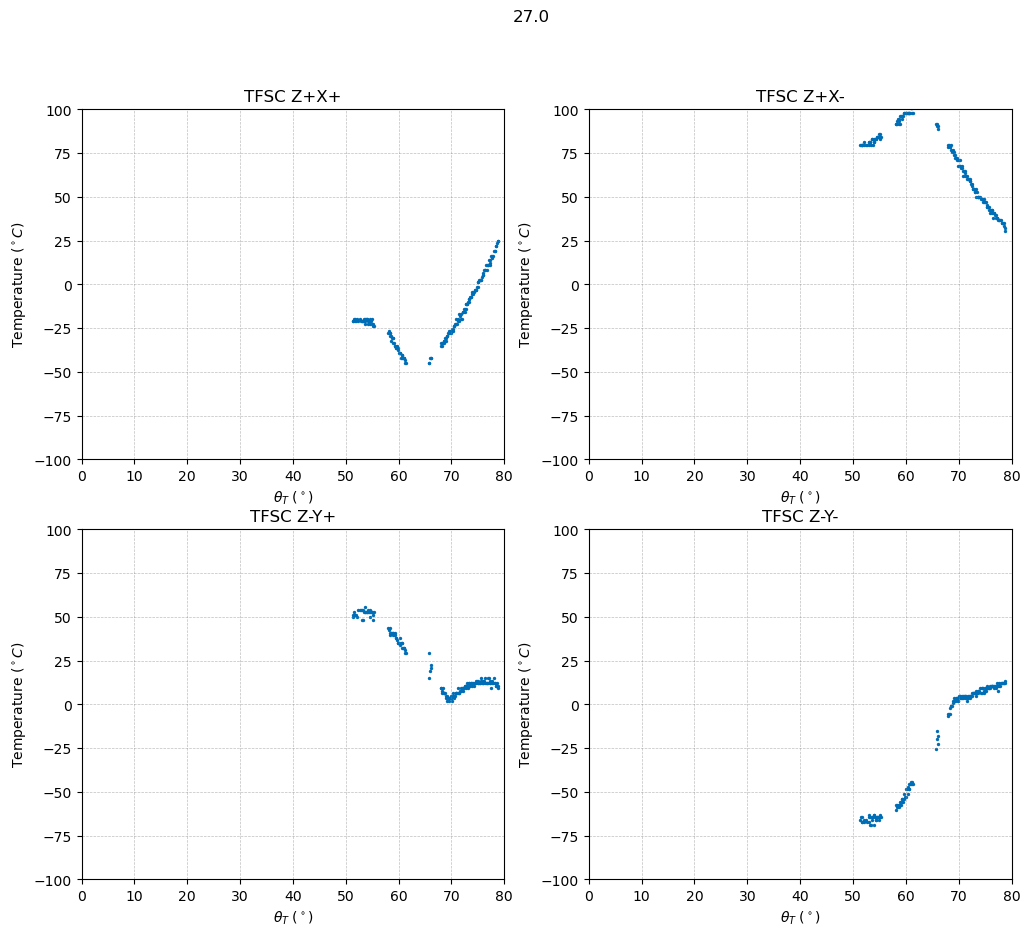

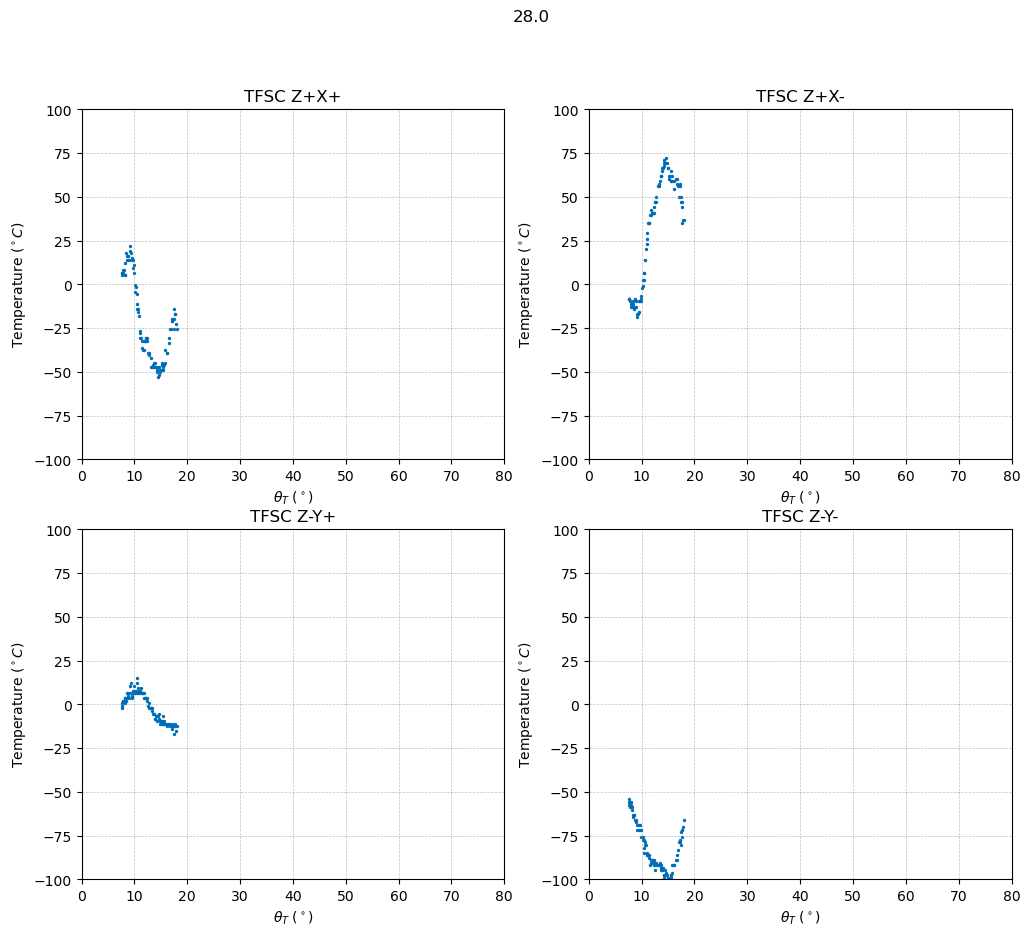

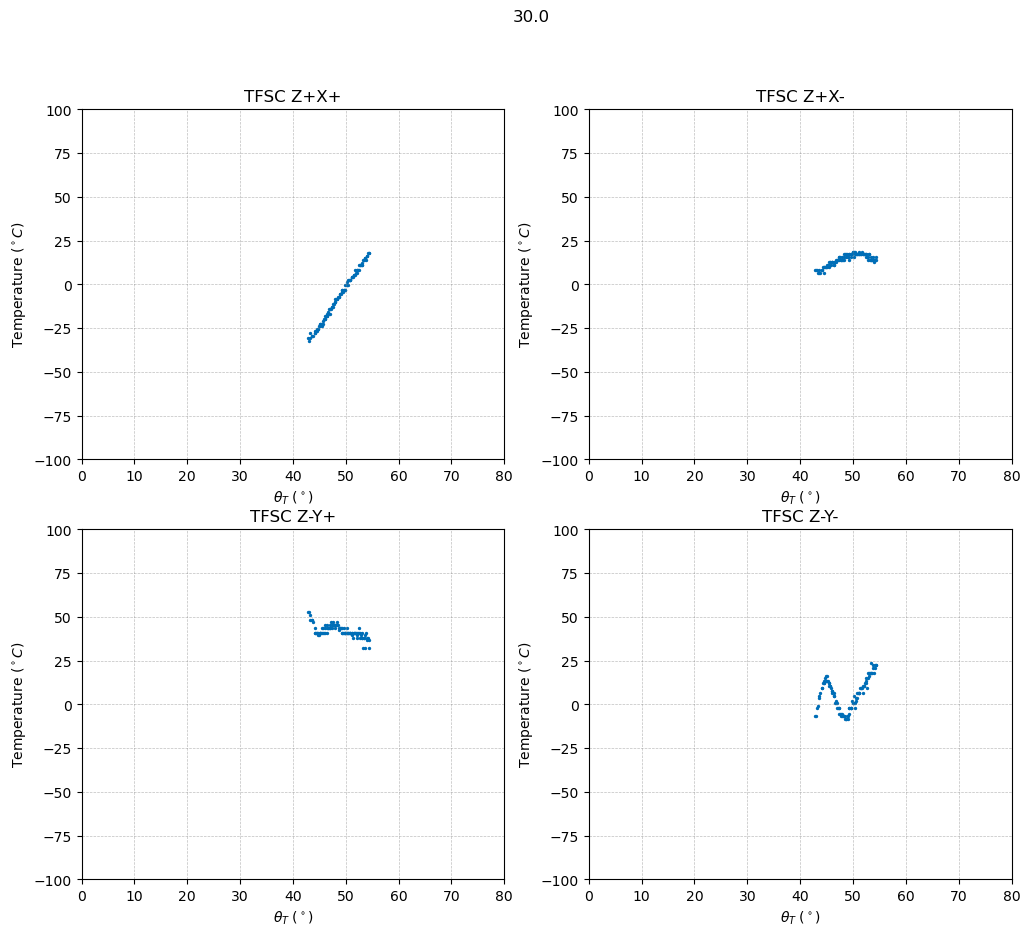

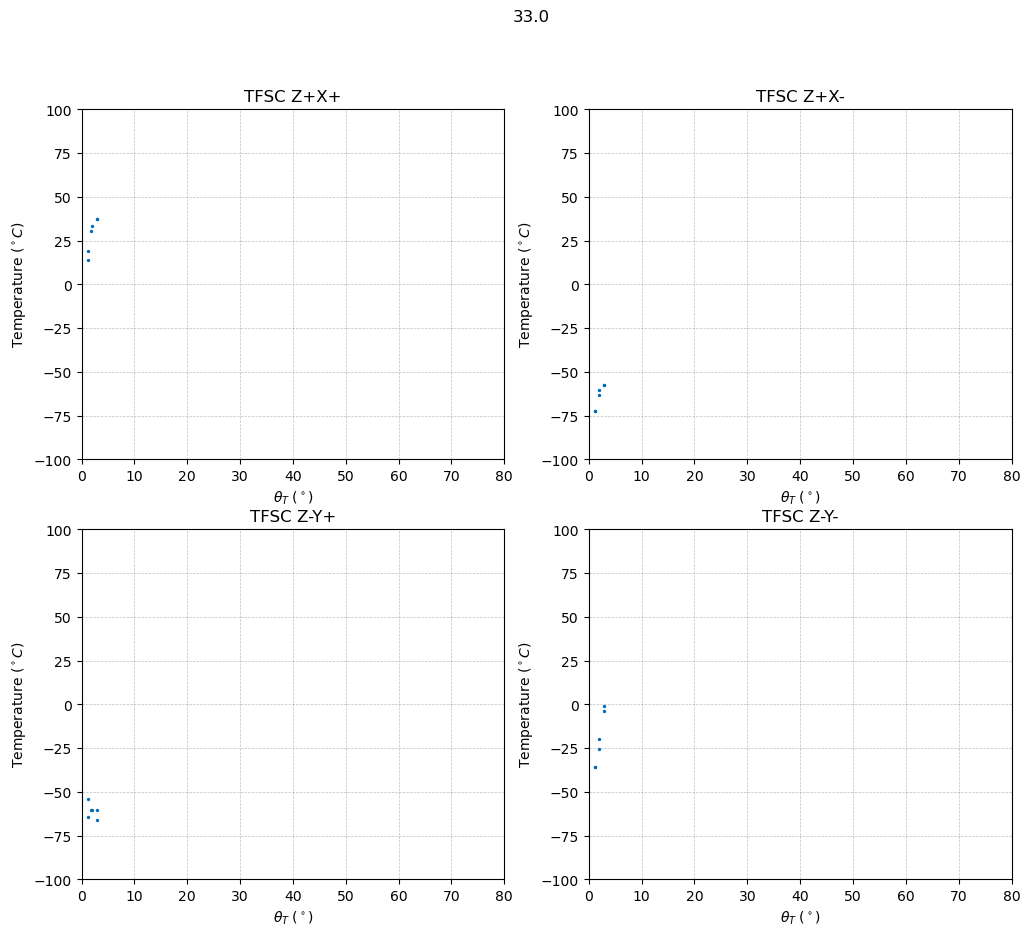

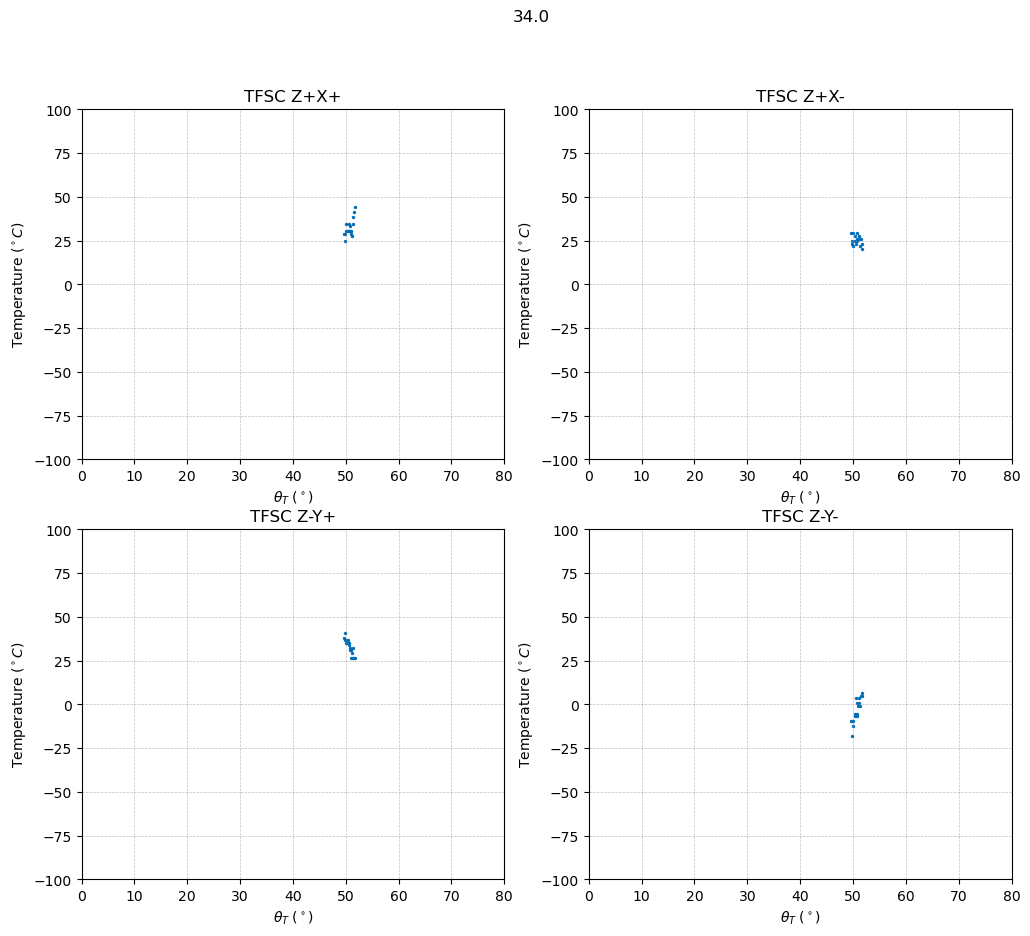

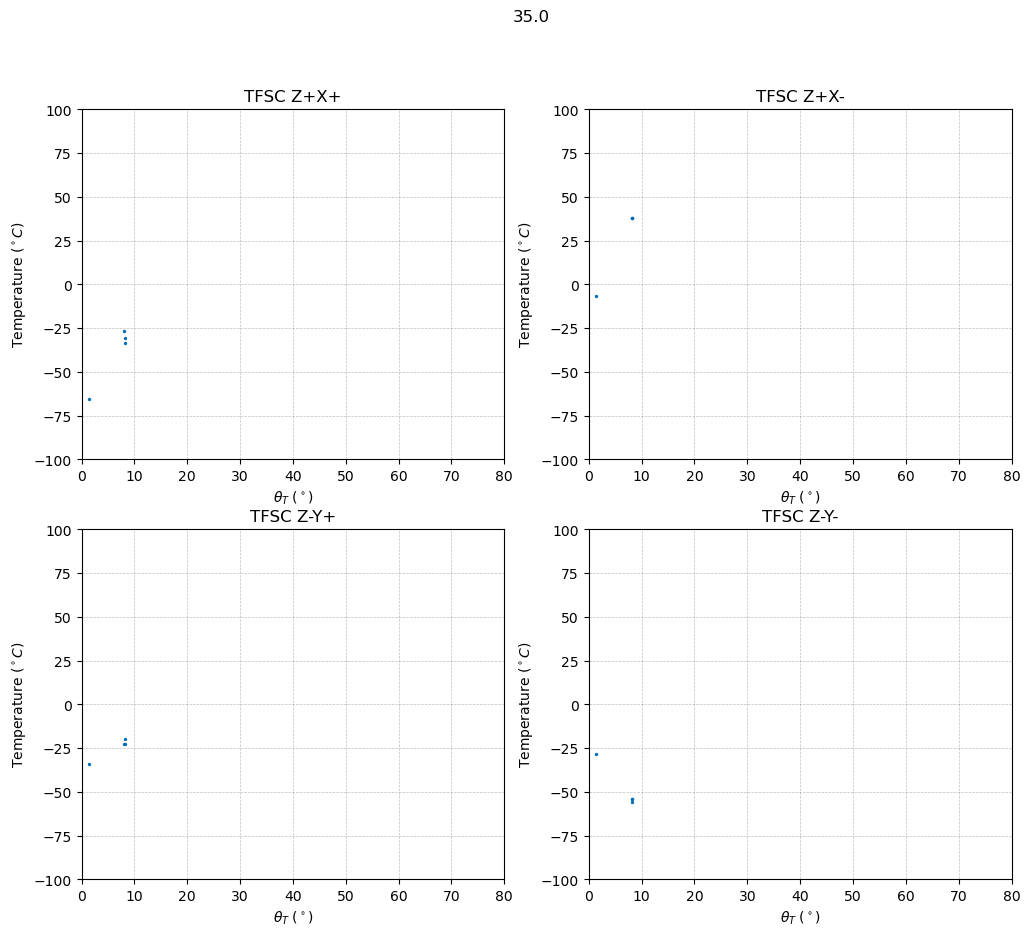

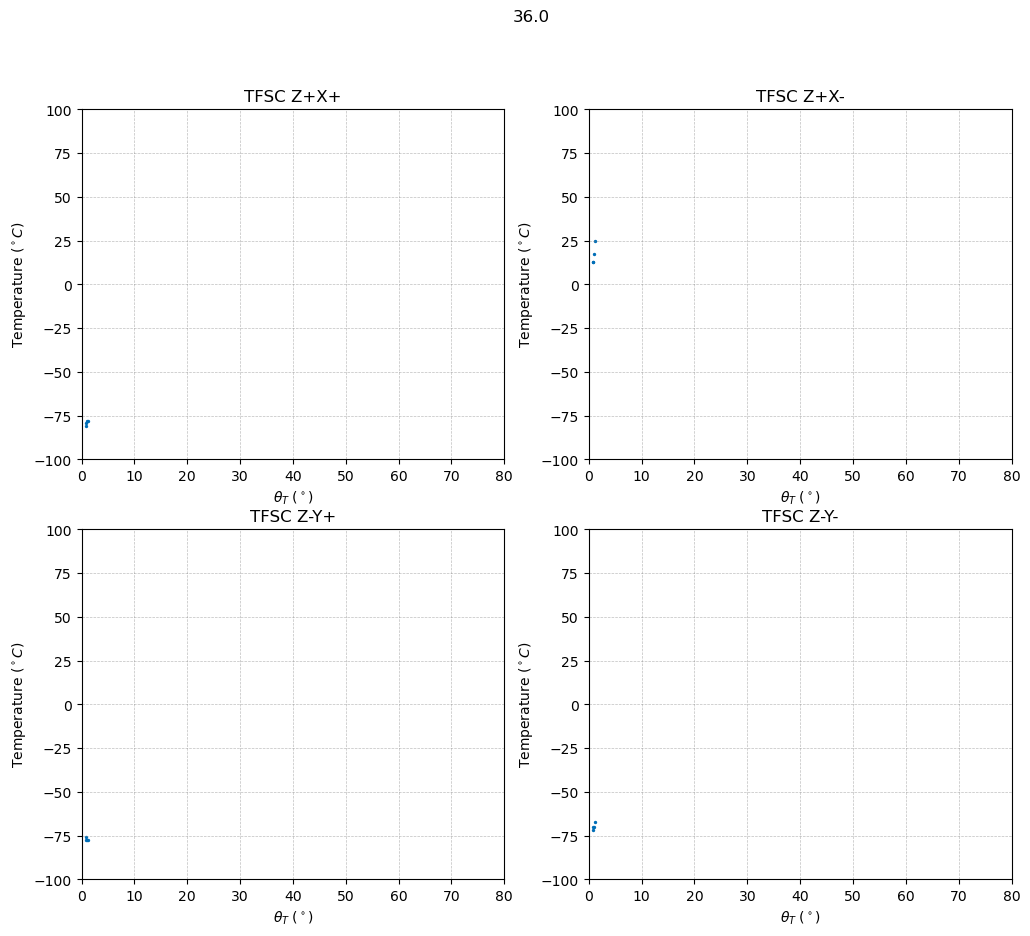

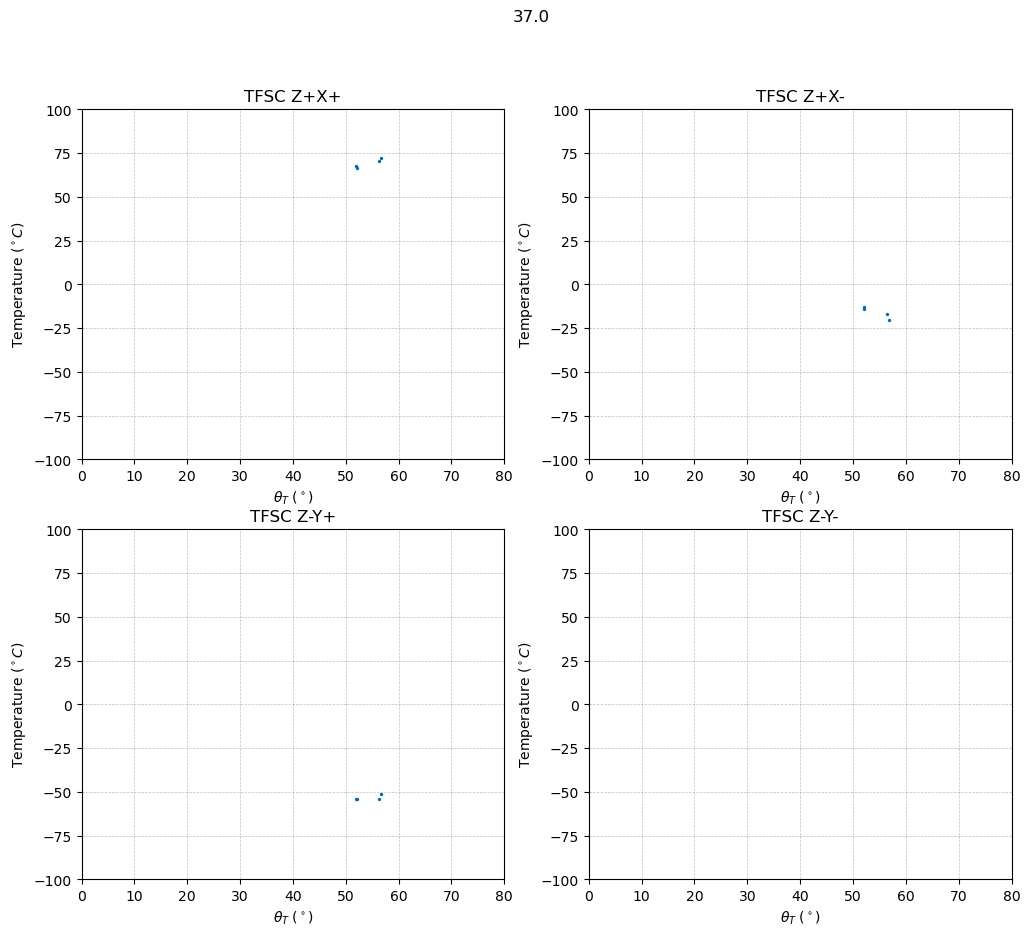

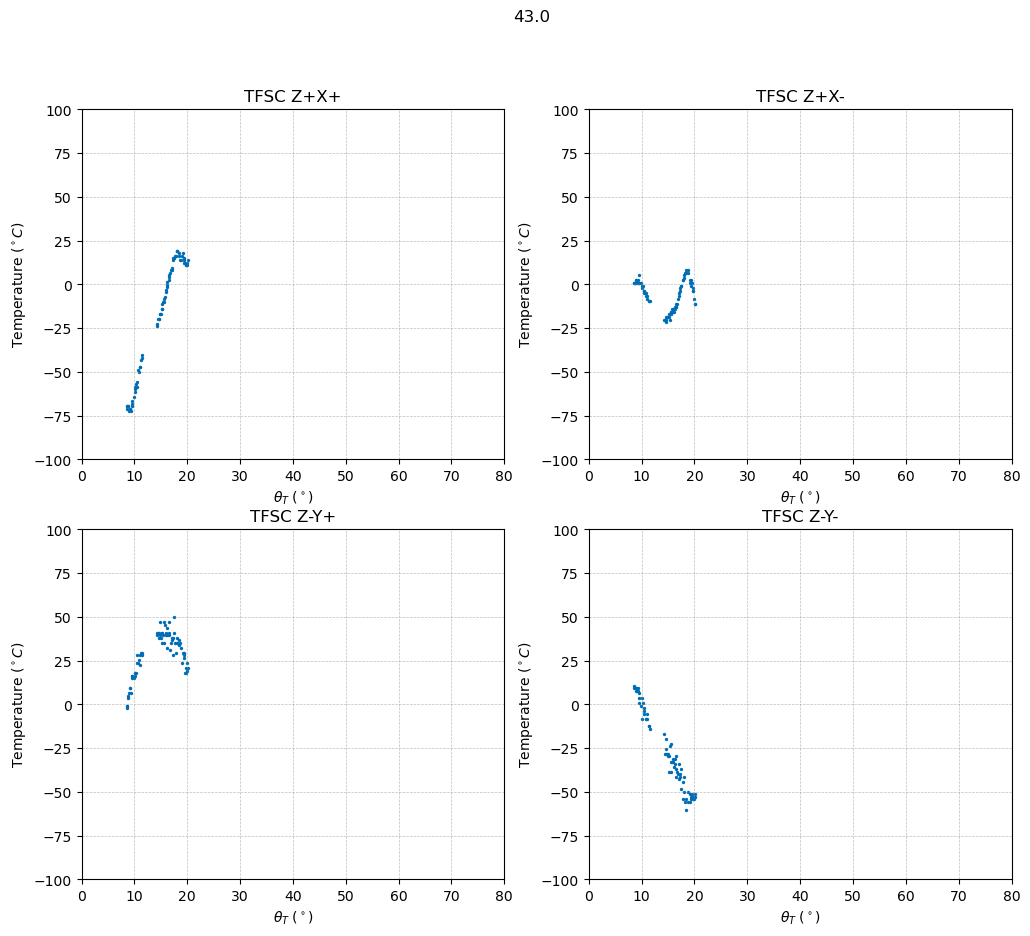

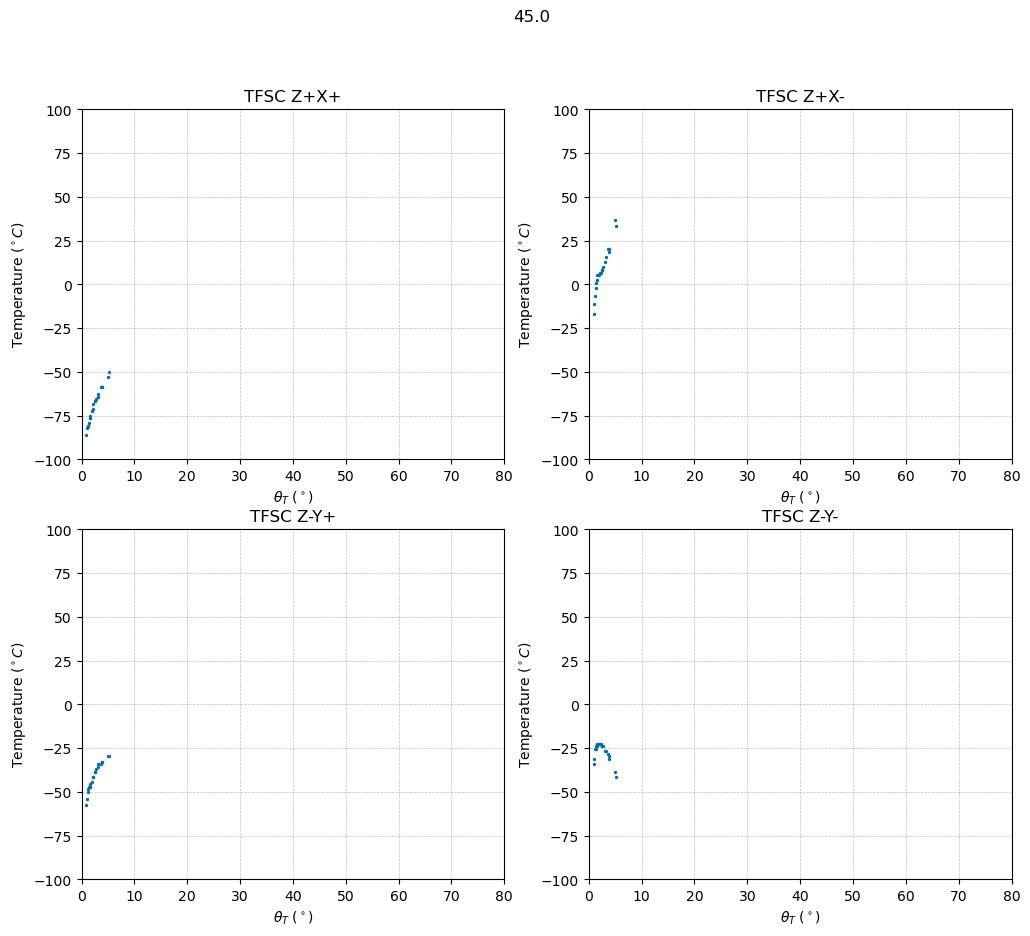

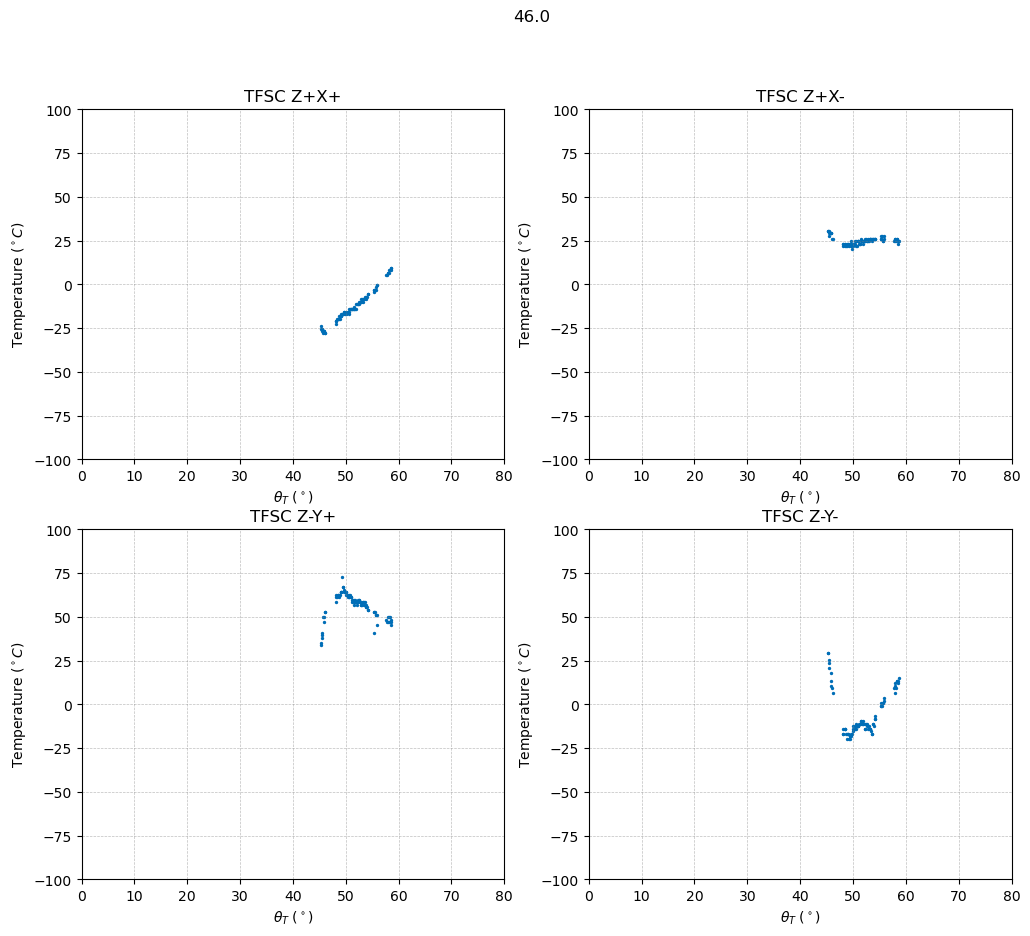

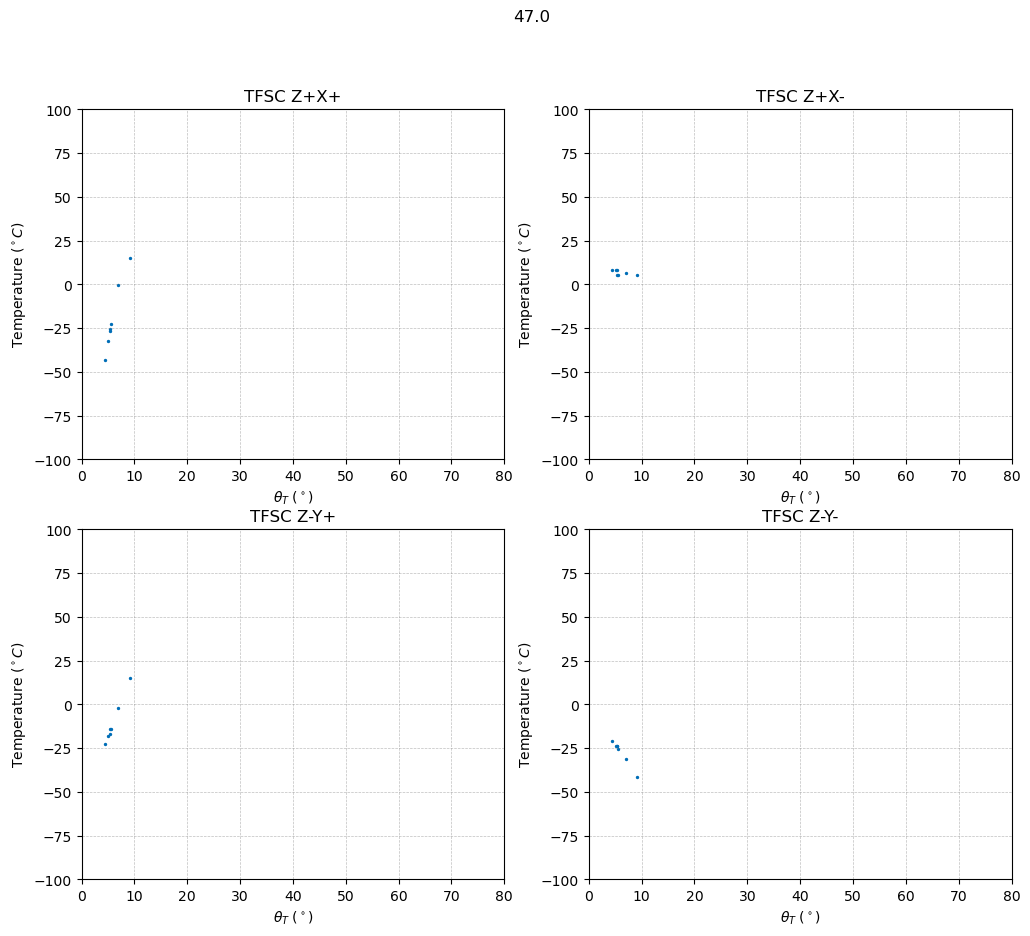

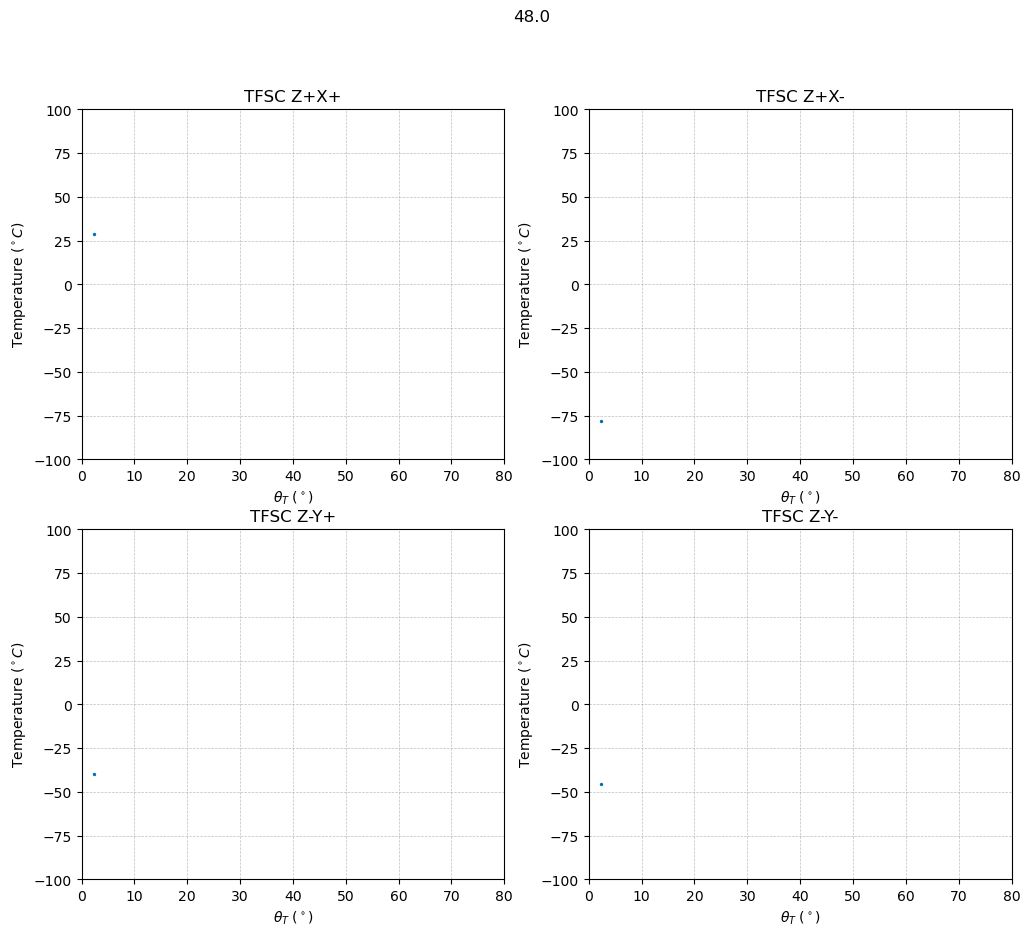

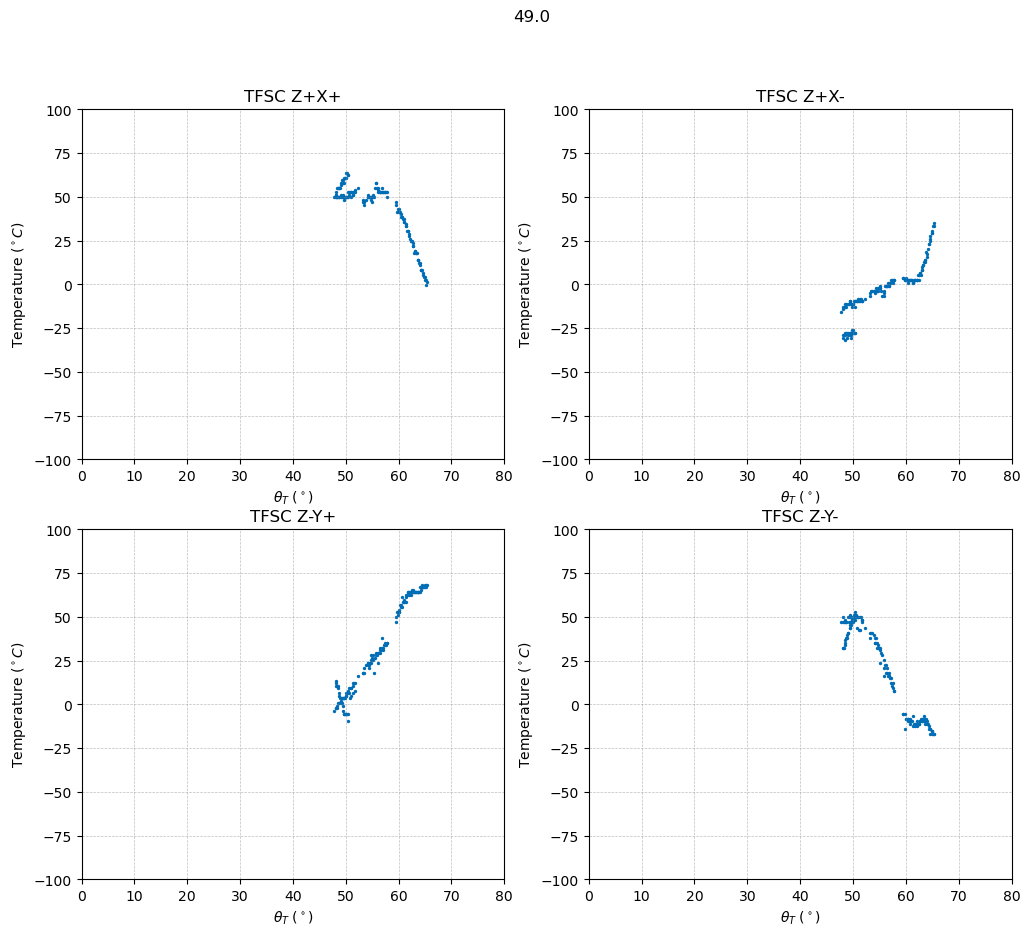

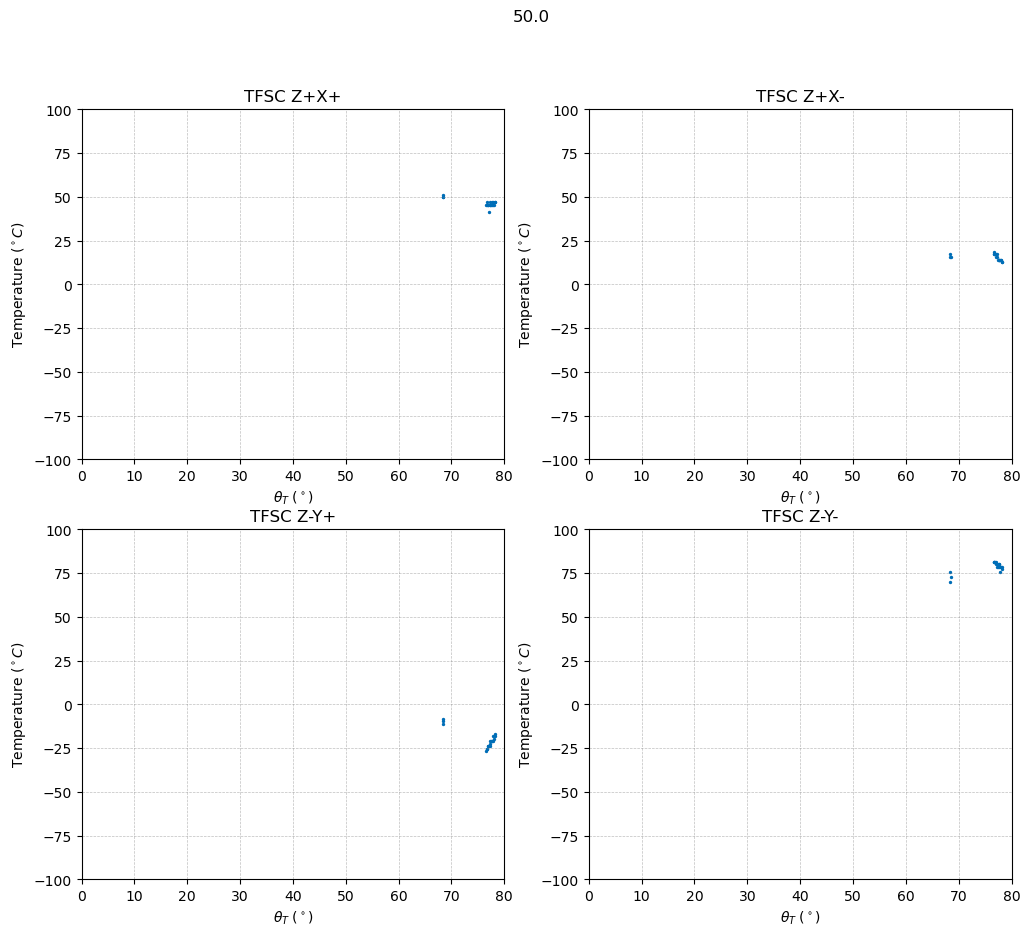

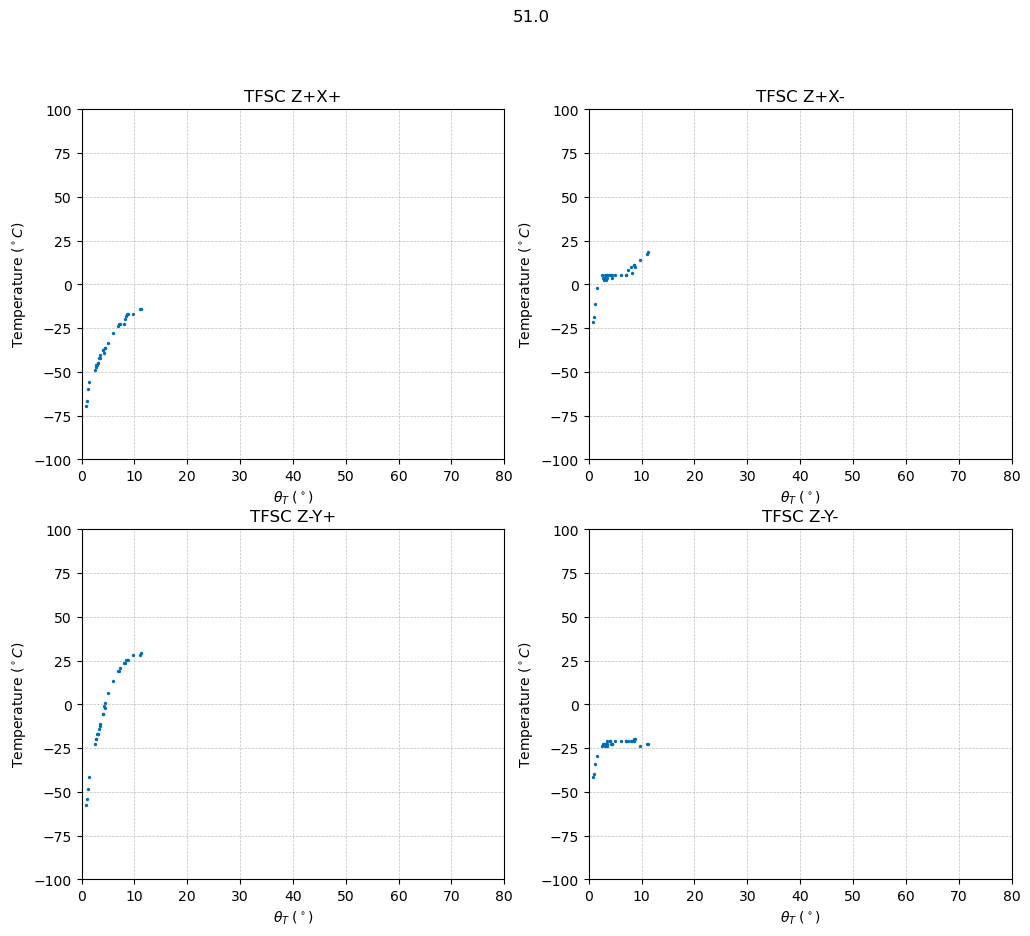

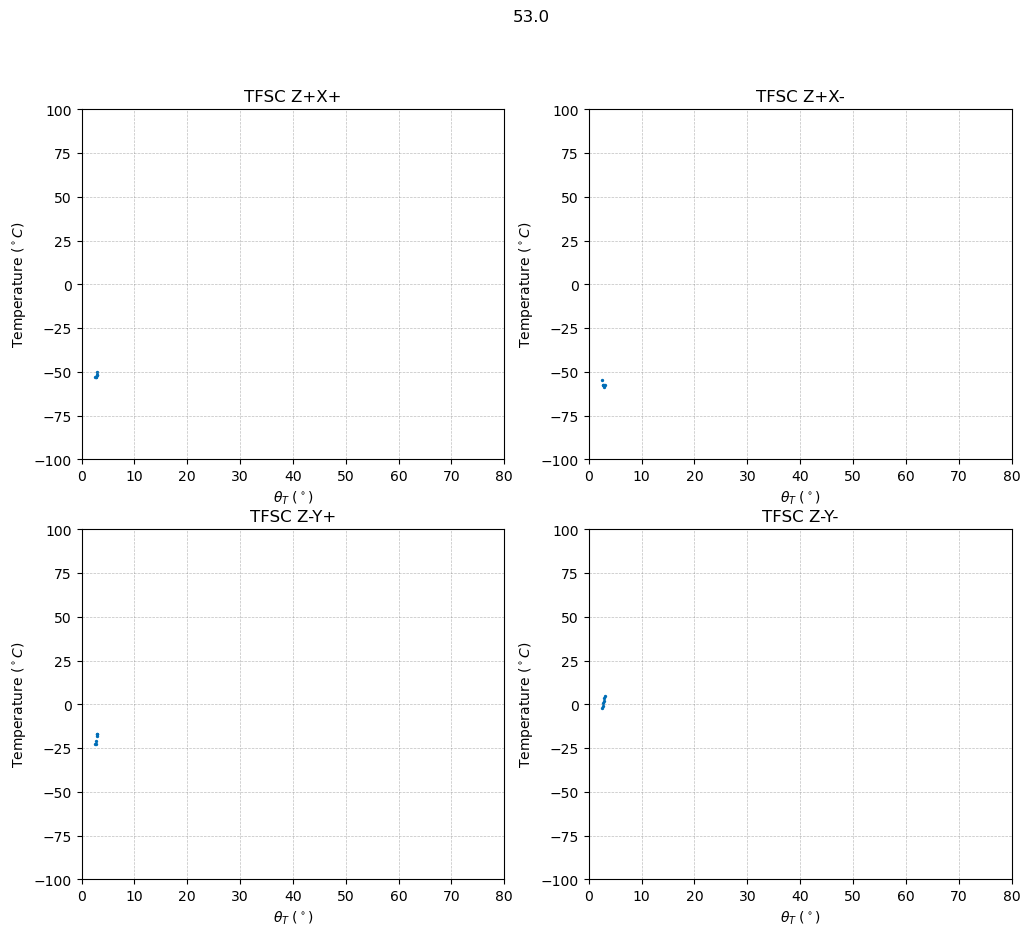

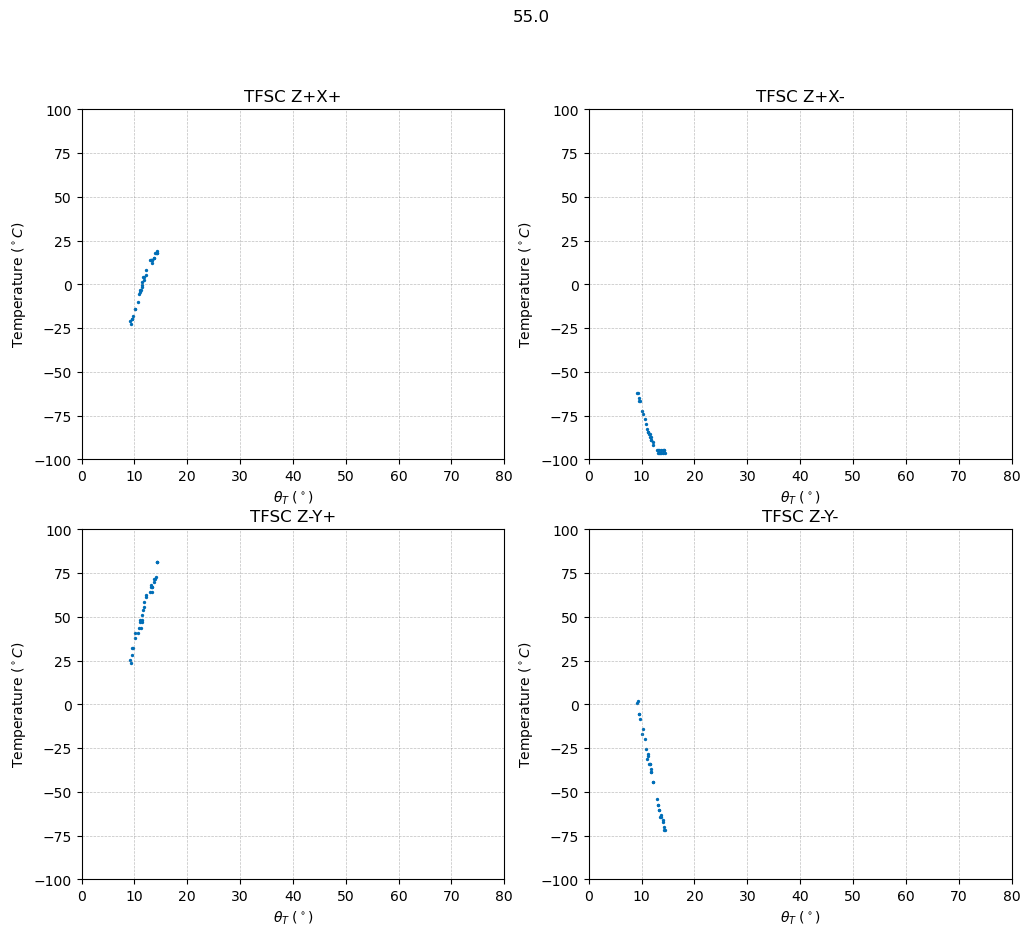

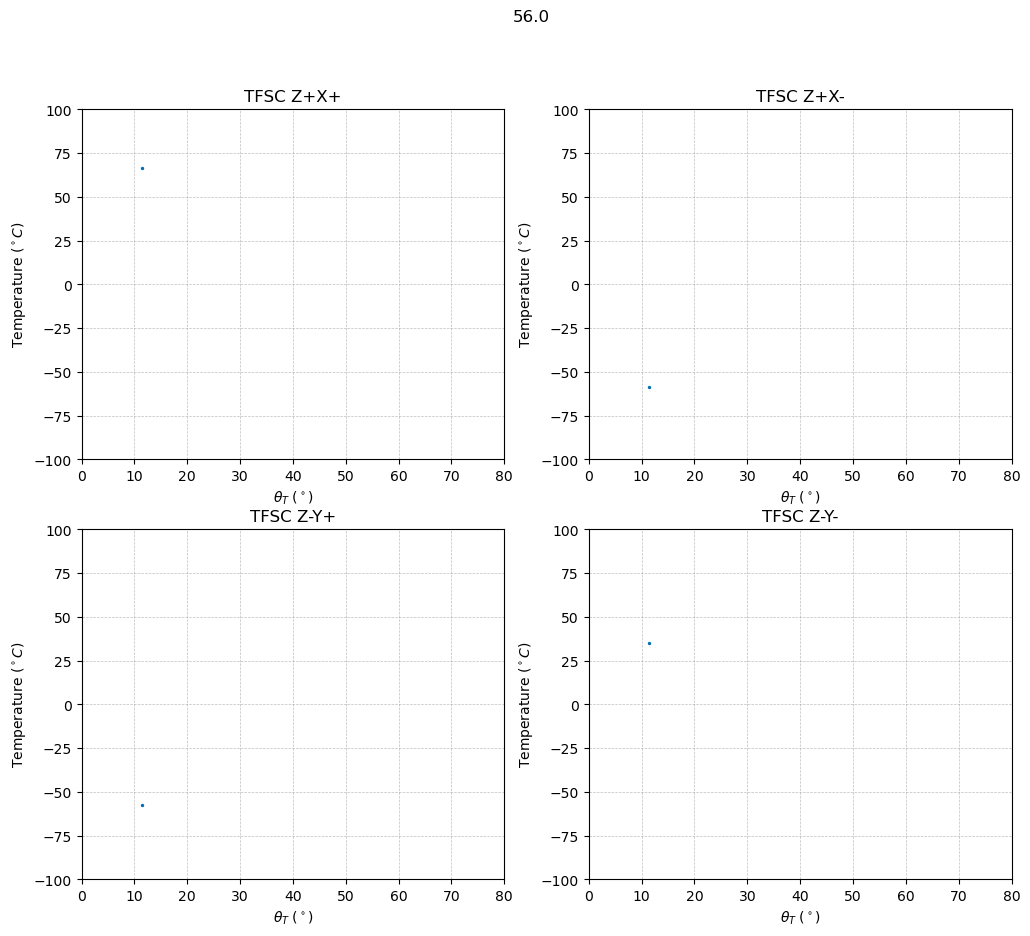

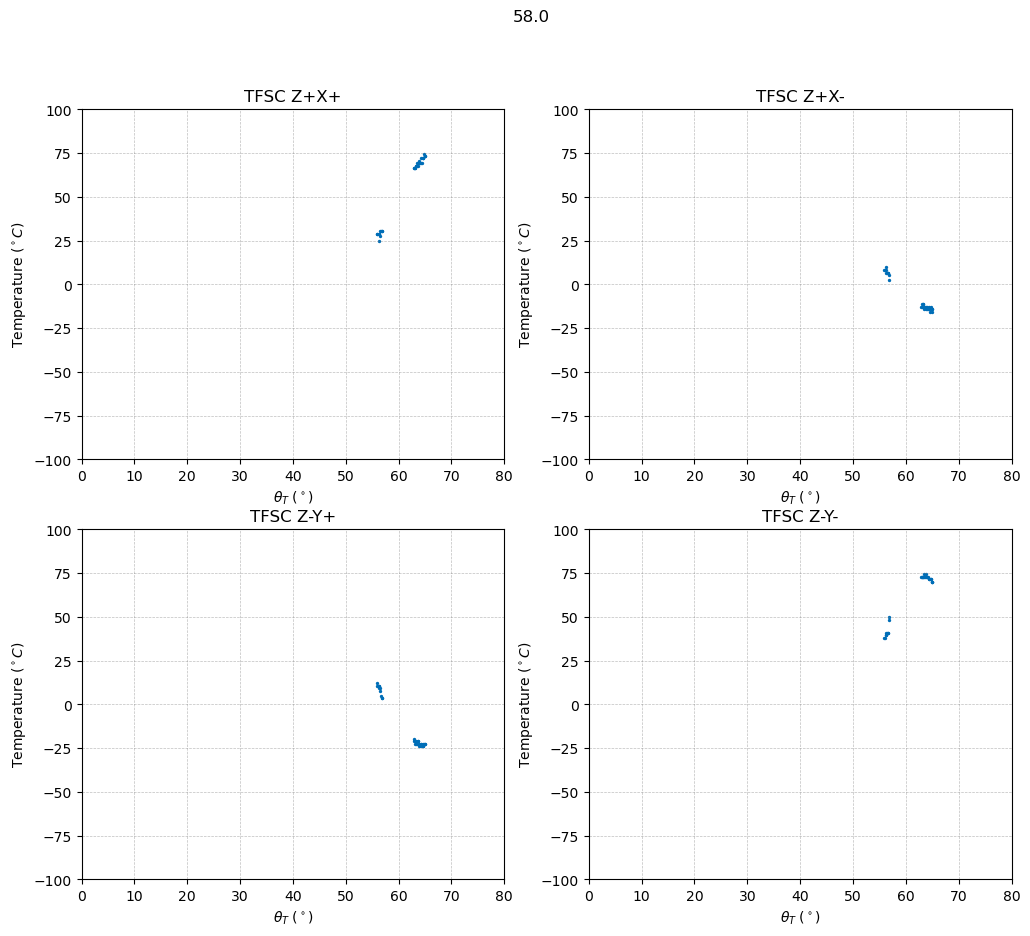

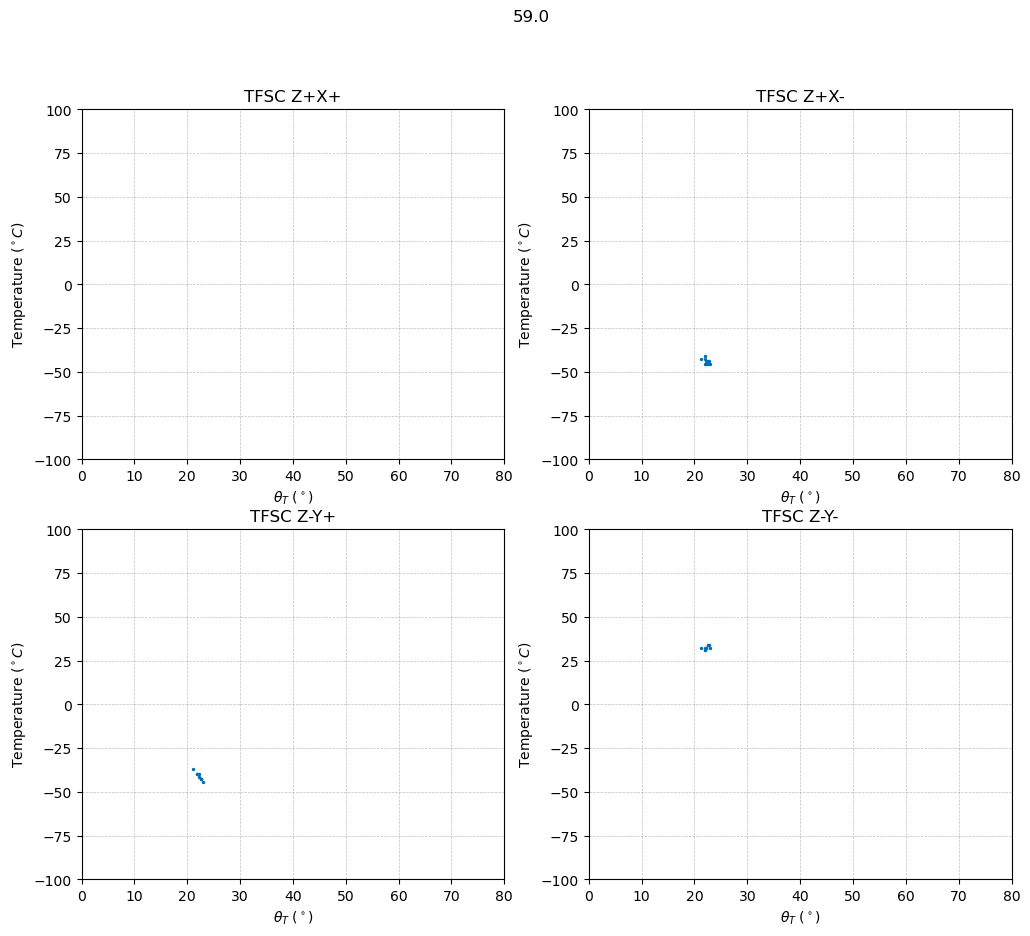

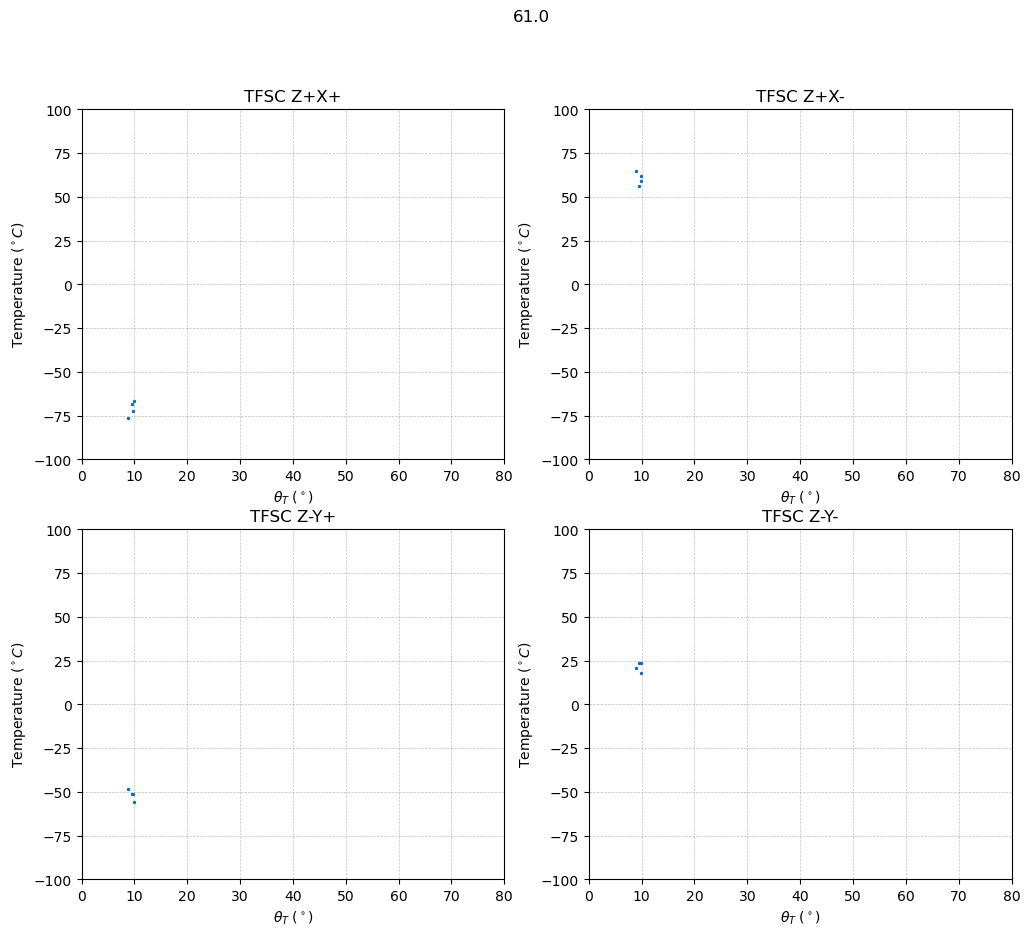

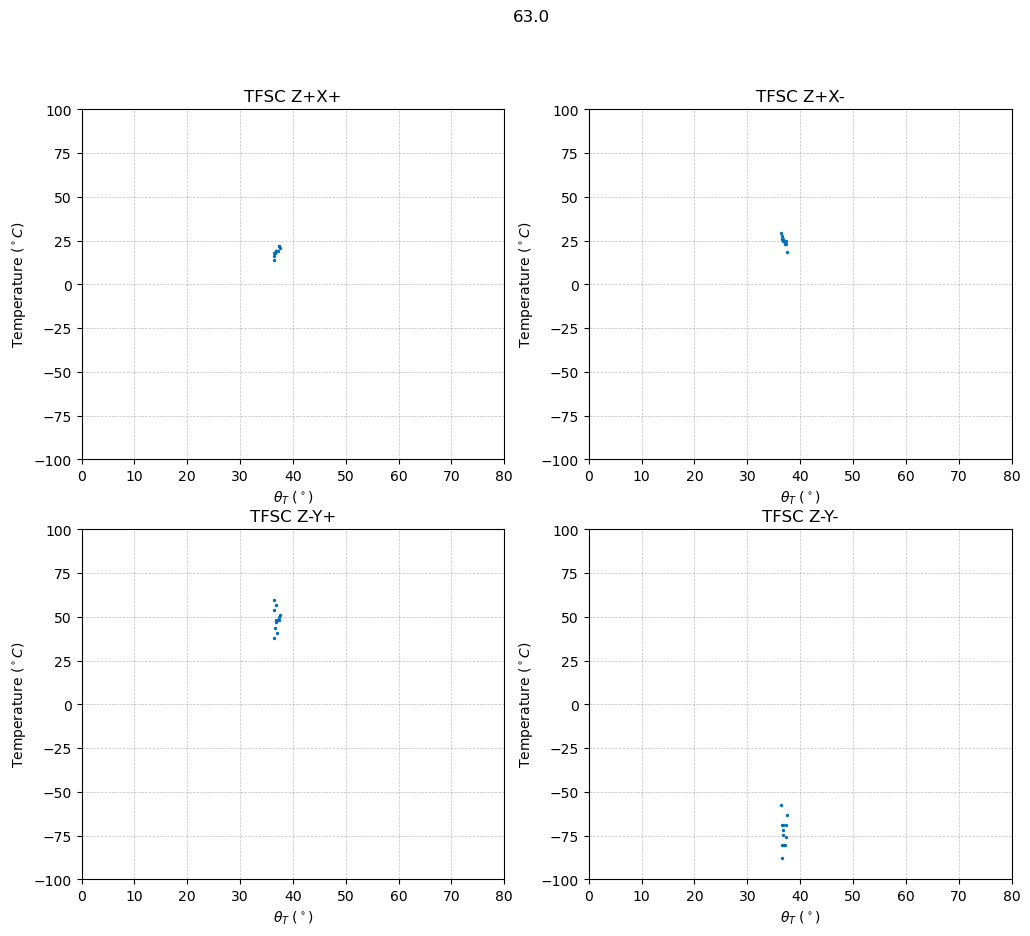

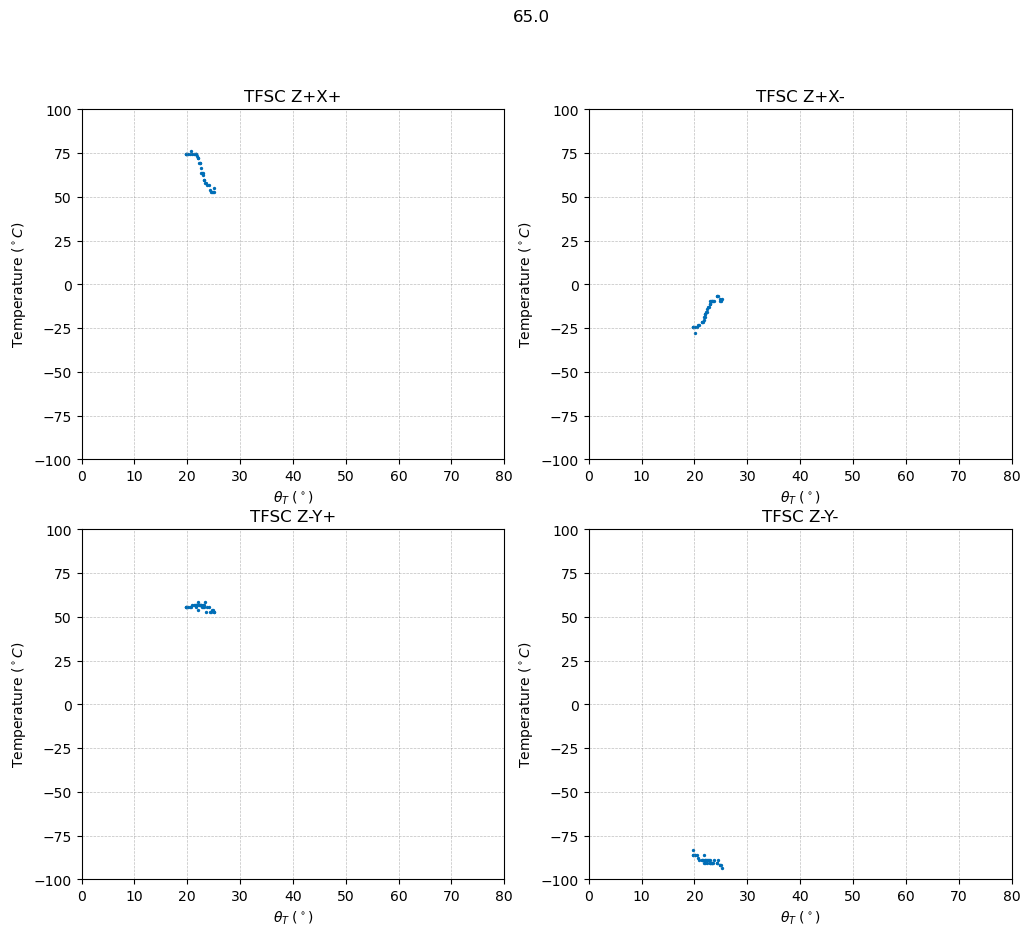

In [25]:
# Plotting the data according to pass number:
for pass_no in pl_df["Pass number"].unique():
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.scatter(
        pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
        pl_df[pl_df["Pass number"] == pass_no]["TFSC Z+X+ Temperature (K)"].to_numpy() - 273.15,
        s=2,
        color=plt_colors[0],
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature $(^\circ C)$")
    plt.title("TFSC Z+X+")
    plt.grid()
    plt.xlim(0, 80)
    plt.ylim(-100, 100)

    plt.subplot(2, 2, 2)
    plt.scatter(
        pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
        pl_df[pl_df["Pass number"] == pass_no]["TFSC Z+X- Temperature (K)"].to_numpy() - 273.15,
        s=2,
        color=plt_colors[0],
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature $(^\circ C)$")
    plt.title("TFSC Z+X-")
    plt.grid()
    plt.xlim(0, 80)
    plt.ylim(-100, 100)

    plt.subplot(2, 2, 3)
    plt.scatter(
        pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
        pl_df[pl_df["Pass number"] == pass_no]["TFSC Z-Y+ Temperature (K)"].to_numpy() - 273.15,
        s=2,
        color=plt_colors[0],
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature $(^\circ C)$")
    plt.title("TFSC Z-Y+")
    plt.grid()
    plt.xlim(0, 80)
    plt.ylim(-100, 100)

    plt.subplot(2, 2, 4)
    plt.scatter(
        pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
        pl_df[pl_df["Pass number"] == pass_no]["TFSC Z-Y- Temperature (K)"].to_numpy() - 273.15,
        s=2,
        color=plt_colors[0],
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature $(^\circ C)$")
    plt.title("TFSC Z-Y-")
    plt.grid()
    plt.xlim(0, 80)
    plt.ylim(-100, 100)

    plt.suptitle(f"{pass_no}")
    plt.show()

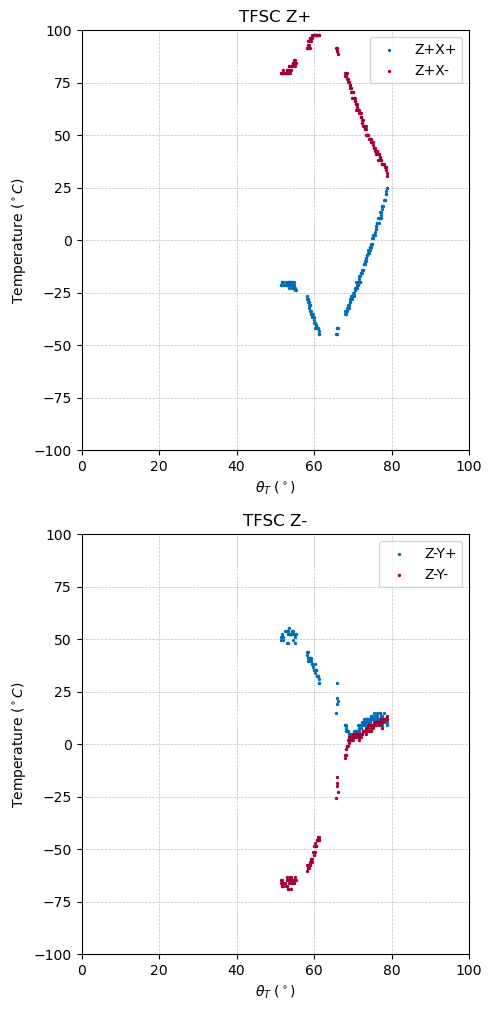

In [45]:
pass_no = 27
plt.figure(figsize=(5, 12))
plt.subplot(2, 1, 1)
plt.scatter(
    pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
    pl_df[pl_df["Pass number"] == pass_no]["TFSC Z+X+ Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
    label="Z+X+",
)

plt.scatter(
    pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
    pl_df[pl_df["Pass number"] == pass_no]["TFSC Z+X- Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[1],
    label="Z+X-",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z+")
plt.grid()
plt.xlim(0, 100)
plt.legend()
plt.ylim(-100, 100)

plt.subplot(2, 1, 2)
plt.scatter(
    pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
    pl_df[pl_df["Pass number"] == pass_no]["TFSC Z-Y+ Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[0],
    label="Z-Y+",
)

plt.scatter(
    pl_df[pl_df["Pass number"] == pass_no]["theta_T (deg)"].to_numpy(),
    pl_df[pl_df["Pass number"] == pass_no]["TFSC Z-Y- Temperature (K)"].to_numpy() - 273.15,
    s=2,
    color=plt_colors[1],
    label="Z-Y-",
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature $(^\circ C)$")
plt.title("TFSC Z-")
plt.grid()
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.legend()


plt.show()

In [35]:
# Loading telemetry data:
TELEM_SAVE_PATH = r"../telemetry-files/delfi-c3/processed-2008-2022/delfi-c3-telemetry-processed-2009.hdf"
frames_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="frames_raw")
frames_df = pd.read_hdf(TELEM_SAVE_PATH, key="frames")
housekeeping_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping_raw")
housekeeping_df = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping")
payload_raw_df = pd.read_hdf(TELEM_SAVE_PATH, key="payload_raw")
payload_df = pd.read_hdf(TELEM_SAVE_PATH, key="payload")

In [36]:
# Loading telemetry data:
TELEM_SAVE_PATH = r"../telemetry-files/delfi-c3/processed-2008-2022/delfi-c3-telemetry-processed-2010.hdf"
frames_raw_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="frames_raw")
frames_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="frames")
housekeeping_raw_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping_raw")
housekeeping_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="housekeeping")
payload_raw_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="payload_raw")
payload_df_1 = pd.read_hdf(TELEM_SAVE_PATH, key="payload")

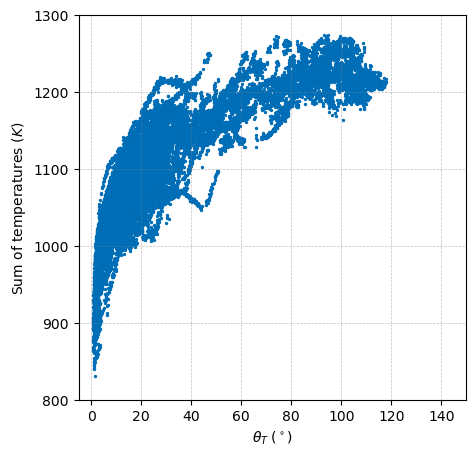

In [43]:
plt.figure(figsize=(5, 5))
plt.scatter(
    payload_df["theta_T (deg)"].to_numpy(),
    payload_df["Total Temperature (K)"].to_numpy(),
    color=plt_colors[0],
    s=2,
)
plt.xlim(-5, 150)
plt.ylim(800, 1300)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Sum of temperatures $(K)$")
plt.grid()